In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [2]:
run ../util/setupConsole_su

In [3]:
cmip6_models = ['bcc-csm2-mr', 'bcc-esm1', 'canesm5', \
                'kace-1-0-g', 'ipsl-cm6a-lr', 'miroc6', \
                'mri-esm2-0', 'noresm2-lm']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)


In [4]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [5]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [6]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

# regrid sacks data
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)


Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc


In [7]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [8]:
era5_txx_maize = xr.Dataset()
era5_sm_on_txx_maize = xr.Dataset()
era5_et_on_txx_maize = xr.Dataset()

era5_txx_soy = xr.Dataset()
era5_sm_on_txx_soy = xr.Dataset()
era5_et_on_txx_soy = xr.Dataset()

era5_txx_wheat = xr.Dataset()
era5_sm_on_txx_wheat = xr.Dataset()
era5_et_on_txx_wheat = xr.Dataset()


era5_tmean_maize = xr.Dataset()
era5_tmean_soy = xr.Dataset()
era5_tmean_wheat = xr.Dataset()

for y,year in enumerate(range(1981,2020+1)):
    
    cur_era5_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_txx_%d_vector.nc'%year)
    cur_era5_txx = cur_era5_txx.assign_coords({'time':year})
    if y == 0:
        era5_txx_maize = cur_era5_txx
    else:
        era5_txx_maize = xr.concat([era5_txx_maize, cur_era5_txx], dim='time')
        
        
    cur_era5_sm_on_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_sm_on_txx_%d_vector.nc'%year)
    cur_era5_sm_on_txx = cur_era5_sm_on_txx.assign_coords({'time':year})
    if y == 0:
        era5_sm_on_txx_maize = cur_era5_sm_on_txx
    else:
        era5_sm_on_txx_maize = xr.concat([era5_sm_on_txx_maize, cur_era5_sm_on_txx], dim='time')


    cur_era5_et_on_txx = xr.open_dataset('era5_txx_tmean/era5_Maize_et_on_txx_%d_vector.nc'%year)
    cur_era5_et_on_txx = cur_era5_et_on_txx.assign_coords({'time':year})
    cur_era5_et_on_txx = 1-cur_era5_et_on_txx
    if y == 0:
        era5_et_on_txx_maize = cur_era5_et_on_txx
    else:
        era5_et_on_txx_maize = xr.concat([era5_et_on_txx_maize, cur_era5_et_on_txx], dim='time')
    
    
    
    cur_era5_txx = xr.open_dataset('era5_txx_tmean/era5_Soybeans_txx_%d_vector.nc'%year)
    cur_era5_txx = cur_era5_txx.assign_coords({'time':year})
    if y == 0:
        era5_txx_soy = cur_era5_txx
    else:
        era5_txx_soy = xr.concat([era5_txx_soy, cur_era5_txx], dim='time')
        
        
    cur_era5_sm_on_txx = xr.open_dataset('era5_txx_tmean/era5_Soybeans_sm_on_txx_%d_vector.nc'%year)
    cur_era5_sm_on_txx = cur_era5_sm_on_txx.assign_coords({'time':year})
    if y == 0:
        era5_sm_on_txx_soy = cur_era5_sm_on_txx
    else:
        era5_sm_on_txx_soy = xr.concat([era5_sm_on_txx_soy, cur_era5_sm_on_txx], dim='time')


    cur_era5_et_on_txx = xr.open_dataset('era5_txx_tmean/era5_Soybeans_et_on_txx_%d_vector.nc'%year)
    cur_era5_et_on_txx = cur_era5_et_on_txx.assign_coords({'time':year})
    cur_era5_et_on_txx = 1-cur_era5_et_on_txx
    if y == 0:
        era5_et_on_txx_soy = cur_era5_et_on_txx
    else:
        era5_et_on_txx_soy = xr.concat([era5_et_on_txx_soy, cur_era5_et_on_txx], dim='time')
        
        
        
        
        
        
    cur_era5_txx = xr.open_dataset('era5_txx_tmean/era5_Wheat_txx_%d_vector.nc'%year)
    cur_era5_txx = cur_era5_txx.assign_coords({'time':year})
    if y == 0:
        era5_txx_wheat = cur_era5_txx
    else:
        era5_txx_wheat = xr.concat([era5_txx_wheat, cur_era5_txx], dim='time')
        
        
    cur_era5_sm_on_txx = xr.open_dataset('era5_txx_tmean/era5_Wheat_sm_on_txx_%d_vector.nc'%year)
    cur_era5_sm_on_txx = cur_era5_sm_on_txx.assign_coords({'time':year})
    if y == 0:
        era5_sm_on_txx_wheat = cur_era5_sm_on_txx
    else:
        era5_sm_on_txx_wheat = xr.concat([era5_sm_on_txx_wheat, cur_era5_sm_on_txx], dim='time')


    cur_era5_et_on_txx = xr.open_dataset('era5_txx_tmean/era5_Wheat_et_on_txx_%d_vector.nc'%year)
    cur_era5_et_on_txx = cur_era5_et_on_txx.assign_coords({'time':year})
    cur_era5_et_on_txx = 1-cur_era5_et_on_txx
    if y == 0:
        era5_et_on_txx_wheat = cur_era5_et_on_txx
    else:
        era5_et_on_txx_wheat = xr.concat([era5_et_on_txx_wheat, cur_era5_et_on_txx], dim='time')
    
        
    if year <= 2016:
        cur_era5_tmean_maize = xr.open_dataset('era5_txx_tmean/era5_Maize_t_mean_%d_vector.nc'%year)
        cur_era5_tmean_maize = cur_era5_tmean_maize.assign_coords({'time':year})
        if y == 0:
            era5_tmean_maize = cur_era5_tmean_maize
        else:
            era5_tmean_maize = xr.concat([era5_tmean_maize, cur_era5_tmean_maize], dim='time')

        cur_era5_tmean_soy = xr.open_dataset('era5_txx_tmean/era5_Soybeans_t_mean_grow_%d.nc'%year)
        cur_era5_tmean_soy = cur_era5_tmean_soy.assign_coords({'time':year})
        if y == 0:
            era5_tmean_soy = cur_era5_tmean_soy
        else:
            era5_tmean_soy = xr.concat([era5_tmean_soy, cur_era5_tmean_soy], dim='time')


        cur_era5_tmean_wheat = xr.open_dataset('era5_txx_tmean/era5_Wheat_t_mean_grow_%d.nc'%year)
        cur_era5_tmean_wheat = cur_era5_tmean_wheat.assign_coords({'time':year})
        if y == 0:
            era5_tmean_wheat = cur_era5_tmean_wheat
        else:
            era5_tmean_wheat = xr.concat([era5_tmean_wheat, cur_era5_tmean_wheat], dim='time')

era5_txx_maize.load()
era5_sm_on_txx_maize.load()
era5_et_on_txx_maize.load()
era5_tmean_maize.load()
era5_tmean_soy.load()
era5_tmean_wheat.load()


<xarray.Dataset>
Dimensions:           (lat: 721, lon: 1440, time: 36)
Coordinates:
  * time              (time) int64 1981 1982 1983 1984 ... 2013 2014 2015 2016
  * lat               (lat) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon               (lon) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    tasmax_grow_mean  (time, lat, lon) float64 nan nan nan ... -44.22 -44.22

In [9]:
era5_sm_on_txx_maize = era5_sm_on_txx_maize.rename({'__xarray_dataarray_variable__':'sm_on_txx'})
era5_et_on_txx_maize = era5_et_on_txx_maize.rename({'__xarray_dataarray_variable__':'et_on_txx'})
era5_txx_maize = era5_txx_maize.rename({'mx2t':'txx'})

era5_sm_on_txx_soy = era5_sm_on_txx_soy.rename({'__xarray_dataarray_variable__':'sm_on_txx'})
era5_et_on_txx_soy = era5_et_on_txx_soy.rename({'__xarray_dataarray_variable__':'et_on_txx'})
era5_txx_soy = era5_txx_soy.rename({'mx2t':'txx'})

era5_sm_on_txx_wheat = era5_sm_on_txx_wheat.rename({'__xarray_dataarray_variable__':'sm_on_txx'})
era5_et_on_txx_wheat = era5_et_on_txx_wheat.rename({'__xarray_dataarray_variable__':'et_on_txx'})
era5_txx_wheat = era5_txx_wheat.rename({'mx2t':'txx'})

era5_tmean_maize = era5_tmean_maize.rename({'mx2t':'t_mean'})

In [10]:
txx_chg_81_maize = np.nanmean(era5_txx_maize.sel(time=slice(2000,2021)).txx.values,axis=0) - np.nanmean(era5_txx_maize.sel(time=slice(1981,2001)).txx.values,axis=0)
sm_on_txx_chg_81_maize = np.nanmean(era5_sm_on_txx_maize.sel(time=slice(2000,2021)).sm_on_txx.values,axis=0) - np.nanmean(era5_sm_on_txx_maize.sel(time=slice(1981,2001)).sm_on_txx.values,axis=0)
et_on_txx_chg_81_maize = np.nanmean(era5_et_on_txx_maize.sel(time=slice(2000,2021)).et_on_txx.values,axis=0) - np.nanmean(era5_et_on_txx_maize.sel(time=slice(1981,2001)).et_on_txx.values,axis=0)

txx_chg_81_soy = np.nanmean(era5_txx_soy.sel(time=slice(2000,2021)).txx.values,axis=0) - np.nanmean(era5_txx_soy.sel(time=slice(1981,2001)).txx.values,axis=0)
sm_on_txx_chg_81_soy = np.nanmean(era5_sm_on_txx_soy.sel(time=slice(2000,2021)).sm_on_txx.values,axis=0) - np.nanmean(era5_sm_on_txx_soy.sel(time=slice(1981,2001)).sm_on_txx.values,axis=0)
et_on_txx_chg_81_soy = np.nanmean(era5_et_on_txx_soy.sel(time=slice(2000,2021)).et_on_txx.values,axis=0) - np.nanmean(era5_et_on_txx_soy.sel(time=slice(1981,2001)).et_on_txx.values,axis=0)

txx_chg_81_wheat = np.nanmean(era5_txx_wheat.sel(time=slice(2000,2021)).txx.values,axis=0) - np.nanmean(era5_txx_wheat.sel(time=slice(1981,2001)).txx.values,axis=0)
sm_on_txx_chg_81_wheat = np.nanmean(era5_sm_on_txx_wheat.sel(time=slice(2000,2021)).sm_on_txx.values,axis=0) - np.nanmean(era5_sm_on_txx_wheat.sel(time=slice(1981,2001)).sm_on_txx.values,axis=0)
et_on_txx_chg_81_wheat = np.nanmean(era5_et_on_txx_wheat.sel(time=slice(2000,2021)).et_on_txx.values,axis=0) - np.nanmean(era5_et_on_txx_wheat.sel(time=slice(1981,2001)).et_on_txx.values,axis=0)


sm_on_txx_81 = np.nanmean(era5_sm_on_txx_maize.sel(time=slice(1981,2001)).sm_on_txx.values,axis=0)
sm_on_txx_01 = np.nanmean(era5_sm_on_txx_maize.sel(time=slice(2000,2021)).sm_on_txx.values,axis=0)

tmean_chg_81 = np.nanmean(era5_tmean_maize.sel(time=slice(2000,2021)).t_mean.values,axis=0) - np.nanmean(era5_tmean_maize.sel(time=slice(1981,2001)).t_mean.values,axis=0)


In [11]:
# for y, year in enumerate(range(1981, 2020+1)):
#     os.rename('%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d.dat'%(dirHeatData, year), '%s/heat-wave-days/et-on-tw/era5_et_on_tw_%d_%d.dat'%(dirHeatData, 95, year))

In [12]:
%%time

rebuild = False
ca_year = 1995

if rebuild:# not os.path.isfile('maize_hw_%d_regrid.dat'%ca_year) and not rebuild:
    crop_ha_lat = np.linspace(90, -90, 2160)
    crop_ha_lon = np.linspace(0, 360, 4320)

    print('processing maize...')
    maize_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Maize/Maize_%d_Area.tif'%(dirAgData, ca_year))
    maize_ha = maize_ha.read(1)
    maize_ha[abs(maize_ha) > 10] = np.nan
    maize_ha = np.roll(maize_ha, -int(maize_ha.shape[1]/2), axis=1)
    
    regridMesh = xr.Dataset({'lat': (['lat'], np.linspace(90, -90, lat.size)),
                             'lon': (['lon'], np.linspace(0, 360, lon.size)),})

    regridder = xe.Regridder(xr.DataArray(data=maize_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    maize_ha_regrid = regridder(maize_ha)
    
    with open('maize_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(maize_ha_regrid, f)
        
    print('processing soy...')
    soy_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Soybean/Soybean_%d_Area.tif'%(dirAgData, ca_year))
    soy_ha = soy_ha.read(1)
    soy_ha[abs(soy_ha) > 10] = np.nan
    soy_ha = np.roll(soy_ha, -int(soy_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=soy_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    soy_ha_regrid = regridder(soy_ha)
    
    with open('soy_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(soy_ha_regrid, f)
      
    
    print('processing wheat...')
    wheat_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Wheat/Wheat_%d_Area.tif'%(dirAgData, ca_year))
    wheat_ha = wheat_ha.read(1)
    wheat_ha[abs(wheat_ha) > 10] = np.nan
    wheat_ha = np.roll(wheat_ha, -int(wheat_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=wheat_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    wheat_ha_regrid = regridder(wheat_ha)
    
    with open('wheat_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(wheat_ha_regrid, f)
    
    
    print('processing rice...')
    rice_ha = rasterio.open('%s/HarvAreaYield_4Crops_95-00-05_Geotiff/Rice/Rice_%d_Area.tif'%(dirAgData, ca_year))
    rice_ha = rice_ha.read(1)
    rice_ha[abs(rice_ha) > 10] = np.nan
    rice_ha = np.roll(rice_ha, -int(rice_ha.shape[1]/2), axis=1)
    
    regridder = xe.Regridder(xr.DataArray(data=rice_ha, dims=['lat', 'lon'], coords={'lat':crop_ha_lat, 'lon':crop_ha_lon}), regridMesh, 'bilinear')
    rice_ha_regrid = regridder(rice_ha)
    
    with open('rice_hw_%d_regrid.dat'%ca_year, 'wb') as f:
        pickle.dump(rice_ha_regrid, f)
else:
    with open('maize_hw_%d_regrid.dat'%1995, 'rb') as f:
        maize_ha_regrid_1995 = pickle.load(f)
    with open('maize_hw_%d_regrid.dat'%2000, 'rb') as f:
        maize_ha_regrid_2000 = pickle.load(f)
    with open('maize_hw_%d_regrid.dat'%2005, 'rb') as f:
        maize_ha_regrid_2005 = pickle.load(f)
        
        
    with open('soy_hw_%d_regrid.dat'%1995, 'rb') as f:
        soy_ha_regrid_1995 = pickle.load(f)
    with open('soy_hw_%d_regrid.dat'%2000, 'rb') as f:
        soy_ha_regrid_2000 = pickle.load(f)
    with open('soy_hw_%d_regrid.dat'%2005, 'rb') as f:
        soy_ha_regrid_2005 = pickle.load(f)
        
    
    with open('wheat_hw_%d_regrid.dat'%1995, 'rb') as f:
        wheat_ha_regrid_1995 = pickle.load(f)
    with open('wheat_hw_%d_regrid.dat'%2000, 'rb') as f:
        wheat_ha_regrid_2000 = pickle.load(f)
    with open('wheat_hw_%d_regrid.dat'%2005, 'rb') as f:
        wheat_ha_regrid_2005 = pickle.load(f)

        
#     crop_ha_regrid = maize_ha_regrid + soy_ha_regrid# + wheat_ha_regrid# + rice_ha_regrid
#     crop_ha_regrid *= 100
#     crop_ha_regrid[crop_ha_regrid>100] = 100

CPU times: user 11.6 ms, sys: 53.9 ms, total: 65.4 ms
Wall time: 2.45 s


In [13]:
# load iizumi
iizumi_maize_ds = xr.Dataset()
iizumi_soy_ds = xr.Dataset()
iizumi_wheat_ds = xr.Dataset()

for y,year in enumerate(range(1981,2016+1)):
    
    iizumi_maize_ds_cur= xr.open_dataset('%s/iizumi/maize_major/yield_%d.nc4'%(dirHeatData,year))
    iizumi_maize_ds_cur = iizumi_maize_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_maize_ds = iizumi_maize_ds_cur
    else:
        iizumi_maize_ds = xr.concat([iizumi_maize_ds, iizumi_maize_ds_cur], dim='time')
        
        
    iizumi_soy_ds_cur= xr.open_dataset('%s/iizumi/soybean/yield_%d.nc4'%(dirHeatData,year))
    iizumi_soy_ds_cur = iizumi_soy_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_soy_ds = iizumi_soy_ds_cur
    else:
        iizumi_soy_ds = xr.concat([iizumi_soy_ds, iizumi_soy_ds_cur], dim='time')
        

    iizumi_wheat_ds_cur= xr.open_dataset('%s/iizumi/wheat/yield_%d.nc4'%(dirHeatData,year))
    iizumi_wheat_ds_cur = iizumi_wheat_ds_cur.assign_coords({'time':year})
    if y == 0:
        iizumi_wheat_ds = iizumi_wheat_ds_cur
    else:
        iizumi_wheat_ds = xr.concat([iizumi_wheat_ds, iizumi_wheat_ds_cur], dim='time')

iizumi_maize_ds = iizumi_maize_ds.reindex(lat=list(reversed(iizumi_maize_ds.lat)))
iizumi_soy_ds = iizumi_soy_ds.reindex(lat=list(reversed(iizumi_soy_ds.lat)))
iizumi_wheat_ds = iizumi_wheat_ds.reindex(lat=list(reversed(iizumi_wheat_ds.lat)))

# regrid iizumi to era5
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder = xe.Regridder(iizumi_maize_ds, regridMesh, 'bilinear', reuse_weights=False)
regridder.clean_weight_file()
iizumi_maize_ds_regrid = regridder(iizumi_maize_ds)

regridder = xe.Regridder(iizumi_soy_ds, regridMesh, 'bilinear', reuse_weights=False)
regridder.clean_weight_file()
iizumi_soy_ds_regrid = regridder(iizumi_soy_ds)

regridder = xe.Regridder(iizumi_wheat_ds, regridMesh, 'bilinear', reuse_weights=False)
regridder.clean_weight_file()
iizumi_wheat_ds_regrid = regridder(iizumi_wheat_ds)

Overwrite existing file: bilinear_360x720_721x1440.nc 
 You can set reuse_weights=True to save computing time.
Remove file bilinear_360x720_721x1440.nc
using dimensions ('lat', 'lon') from data variable var as the horizontal dimensions for this dataset.
Create weight file: bilinear_360x720_721x1440.nc
Remove file bilinear_360x720_721x1440.nc
using dimensions ('lat', 'lon') from data variable var as the horizontal dimensions for this dataset.
Create weight file: bilinear_360x720_721x1440.nc
Remove file bilinear_360x720_721x1440.nc
using dimensions ('lat', 'lon') from data variable var as the horizontal dimensions for this dataset.


In [14]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_irr = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear', reuse_weights=True)

irrigationData_regrid = regridder_irr(irrigationData)
irrigationData_regrid_1d = irrigationData_regrid.reshape([irrigationData_regrid.size,1])

Reuse existing file: bilinear_2160x4320_721x1440.nc


In [15]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [16]:
ds_grow_r_t_et_total_evap_61_21 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_2021_detrend.nc')
ds_grow_r_t_et_total_evap_61_21.load()

ds_grow_r_t_et_total_evap_61_81 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_1980_detrend.nc')
ds_grow_r_t_et_total_evap_61_81.load()

ds_grow_r_t_et_total_evap_71_91 = xr.open_dataset('r_t_et_era5_total_evaporation_1971_1990_detrend.nc')
ds_grow_r_t_et_total_evap_71_91.load()

ds_grow_r_t_et_total_evap_81_01 = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001_detrend.nc')
ds_grow_r_t_et_total_evap_81_01.load()

ds_grow_r_t_et_total_evap_81_01_soy = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001_detrend-Soybeans.nc')
ds_grow_r_t_et_total_evap_81_01_soy.load()

ds_grow_r_t_et_total_evap_81_01_wheat = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2001_detrend-Wheat.nc')
ds_grow_r_t_et_total_evap_81_01_wheat.load()

ds_grow_r_t_et_total_evap_91_11 = xr.open_dataset('r_t_et_era5_total_evaporation_1991_2010_detrend.nc')
ds_grow_r_t_et_total_evap_91_11.load()

ds_grow_r_t_et_total_evap_01_21 = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021_detrend.nc')
ds_grow_r_t_et_total_evap_01_21.load()

ds_grow_r_t_et_total_evap_01_21_soy = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021_detrend-Soybeans.nc')
ds_grow_r_t_et_total_evap_01_21_soy.load()

ds_grow_r_t_et_total_evap_01_21_wheat = xr.open_dataset('r_t_et_era5_total_evaporation_2001_2021_detrend-Wheat.nc')
ds_grow_r_t_et_total_evap_01_21_wheat.load()

ds_grow_r_t_et_total_evap_61_91 = xr.open_dataset('r_t_et_era5_total_evaporation_1961_1991_detrend.nc')
ds_grow_r_t_et_total_evap_61_91.load()

ds_grow_r_t_et_total_evap_91_21 = xr.open_dataset('r_t_et_era5_total_evaporation_1991_2021_detrend.nc')
ds_grow_r_t_et_total_evap_91_21.load()

ds_grow_r_t_et_total_evap_81_16 = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2016_detrend.nc')
ds_grow_r_t_et_total_evap_81_16.load()

ds_grow_r_t_et_total_evap_81_16_soy = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2016_detrend-Soybeans.nc')
ds_grow_r_t_et_total_evap_81_16_soy.load()

ds_grow_r_t_et_total_evap_81_16_wheat = xr.open_dataset('r_t_et_era5_total_evaporation_1981_2016_detrend-Wheat.nc')
ds_grow_r_t_et_total_evap_81_16_wheat.load();

ds_grow_r_sm_et_total_evap_81_16 = xr.open_dataset('r_sm_et_era5_1981_2016_detrend-Maize.nc')
ds_grow_r_sm_et_total_evap_81_16.load();

ds_grow_r_t_netrad_total_evap_81_16 = xr.open_dataset('r_t_netrad_era5_1981_2016_detrend-Maize.nc')
ds_grow_r_t_netrad_total_evap_81_16.load();

ds_grow_r_netrad_et_total_evap_81_16 = xr.open_dataset('r_netrad_et_era5_1981_2016_detrend-Maize-solar.nc')
# ds_grow_r_netrad_et_total_evap_81_16 = ds_grow_r_netrad_et_total_evap_81_16.rename({'r_t_netrad':'r_netrad_et'})
ds_grow_r_netrad_et_total_evap_81_16.load();


In [17]:
yearRange = np.arange(1981, 2020+1)

In [18]:
maize_chg = maize_ha_regrid_2005-maize_ha_regrid_1995
soy_chg = soy_ha_regrid_2005-soy_ha_regrid_1995
wheat_chg = wheat_ha_regrid_2005-wheat_ha_regrid_1995

In [20]:
rebuild = False

if rebuild:
    
    
    crop_ha_regrid_shift = crop_ha_regrid.copy()
    crop_ha_regrid_shift_up = crop_ha_regrid.copy()
    crop_ha_regrid_below = crop_ha_regrid.copy()
    crop_ha_regrid_above = crop_ha_regrid.copy()
    
    crop_ha_regrid_up_down = crop_ha_regrid.copy()
    crop_ha_regrid_down_up = crop_ha_regrid.copy()

    maize_chg_shift = maize_chg.copy()
    maize_chg_shift_up = maize_chg.copy()
    maize_chg_below = maize_chg.copy()
    maize_chg_above = maize_chg.copy()


    for x in range(crop_ha_regrid.shape[0]):
        if x%10 == 0: print(x)
        for y in range(crop_ha_regrid.shape[1]):
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0):
                crop_ha_regrid_shift[x,y]=np.nan
                
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] > 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] < 0):
                crop_ha_regrid_shift_up[x,y]=np.nan

            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] < 0):
                crop_ha_regrid_below[x,y]=np.nan

            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] > 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0):
                crop_ha_regrid_above[x,y]=np.nan
                
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] > 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] < 0 \
                   and ds_grow_r_t_et_total_evap_61_81.r_t_et.values[x,y] > 0):
                crop_ha_regrid_down_up[x,y]=np.nan
                
            if not (ds_grow_r_t_et_total_evap_01_21.r_t_et.values[x,y] < 0 and ds_grow_r_t_et_total_evap_81_01.r_t_et.values[x,y] > 0 \
                   and ds_grow_r_t_et_total_evap_61_81.r_t_et.values[x,y] < 0):
                crop_ha_regrid_up_down[x,y]=np.nan


                
#     with open('crop_rt_below_1981-2000_2001-2021-detrend.dat', 'wb') as f:
#         pickle.dump(crop_ha_regrid_below, f)
#     with open('crop_rt_above_1981-2000_2001-2021-detrend.dat', 'wb') as f:
#             pickle.dump(crop_ha_regrid_above, f)
#     with open('crop_rt_shift_1981-2000_2001-2021-detrend.dat', 'wb') as f:
#             pickle.dump(crop_ha_regrid_shift, f)
#     with open('crop_rt_shift_up_1981-2000_2001-2021-detrend.dat', 'wb') as f:
#             pickle.dump(crop_ha_regrid_shift_up, f)
            
    with open('crop_rt_shift_down_up-detrend.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_shift_up, f)
    with open('crop_rt_shift_up_down-detrend.dat', 'wb') as f:
            pickle.dump(crop_ha_regrid_shift_up, f)
else:

    yr = '1961-1980_1981-2000'
    with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_below_61 = pickle.load(f)
    with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_above_61 = pickle.load(f)
    with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_61 = pickle.load(f)
    with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_up_61 = pickle.load(f)
        
    yr = '1971-1990_1991-2010'
    with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_below_71 = pickle.load(f)
    with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_above_71 = pickle.load(f)
    with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_71 = pickle.load(f)
    with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_up_71 = pickle.load(f)
        
    yr = '1981-2000_2001-2021'
    with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_below_81 = pickle.load(f)
    with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_above_81 = pickle.load(f)
    with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_81 = pickle.load(f)
    with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
        crop_ha_regrid_shift_up_81 = pickle.load(f)
        
    with open('crop_rt_shift_down_up-detrend.dat', 'rb') as f:
        crop_ha_regrid_down_up = pickle.load(f)
    with open('crop_rt_shift_up_down-detrend.dat', 'rb') as f:
        crop_ha_regrid_up_down = pickle.load(f)
        
#     yr = '1961-1990_1991-2021'
#     with open('crop_rt_below_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_below_30y_61 = pickle.load(f)
#     with open('crop_rt_above_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_above_30y_61 = pickle.load(f)
#     with open('crop_rt_shift_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_shift_30y_61 = pickle.load(f)
#     with open('crop_rt_shift_up_%s-detrend.dat'%yr, 'rb') as f:
#         crop_ha_regrid_shift_up_30y_61 = pickle.load(f)

In [21]:
n_total = np.where((~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size

shift_pct_61 = np.where((~np.isnan(crop_ha_regrid_shift_61)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_71 = np.where((~np.isnan(crop_ha_regrid_shift_71)) & \
                       (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_81 = np.where((~np.isnan(crop_ha_regrid_shift_81)) & \
                       (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

shift_pct_up_61 = np.where((~np.isnan(crop_ha_regrid_shift_up_61)) & \
                          (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_up_71 = np.where((~np.isnan(crop_ha_regrid_shift_up_71)) & \
                           (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
shift_pct_up_81 = np.where((~np.isnan(crop_ha_regrid_shift_up_81)) & \
                           (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

below_pct_61 = np.where((~np.isnan(crop_ha_regrid_below_61)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
below_pct_71 = np.where((~np.isnan(crop_ha_regrid_below_71)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
below_pct_81 = np.where((~np.isnan(crop_ha_regrid_below_81)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

above_pct_61 = np.where((~np.isnan(crop_ha_regrid_above_61)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
above_pct_71 = np.where((~np.isnan(crop_ha_regrid_above_71)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total
above_pct_81 = np.where((~np.isnan(crop_ha_regrid_above_81)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total


down_up_pct = np.where((~np.isnan(crop_ha_regrid_down_up)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & \
                    (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & \
                    (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total

up_down_pct = np.where((~np.isnan(crop_ha_regrid_up_down)) & \
                        (~np.isnan(crop_ha_regrid)) & (~np.isnan(ds_grow_r_t_et_total_evap_01_21.r_t_et.values)) & \
                    (~np.isnan(ds_grow_r_t_et_total_evap_91_11.r_t_et.values)) & \
                    (~np.isnan(ds_grow_r_t_et_total_evap_81_01.r_t_et.values)))[0].size/n_total


r_t_et_01_21 = ds_grow_r_t_et_total_evap_01_21.r_t_et.values.reshape([ds_grow_r_t_et_total_evap_01_21.r_t_et.values.size])
r_t_et_81_01 = ds_grow_r_t_et_total_evap_81_01.r_t_et.values.reshape([ds_grow_r_t_et_total_evap_81_01.r_t_et.values.size])
r_t_et_61_21 = ds_grow_r_t_et_total_evap_61_21.r_t_et.values.reshape([ds_grow_r_t_et_total_evap_61_21.r_t_et.values.size])


In [22]:
up_down_pct

0.030714916151809355

In [23]:
down_up_pct

0.030714916151809355

In [24]:
ind = np.where((r_t_et_01_21<0) & (r_t_et_81_01<0) & (crop_ha_regrid_1d.reshape([crop_ha_regrid_1d.shape[0]]) > 0))[0]
r_t_et_chg_below = np.nanmean(r_t_et_01_21[ind])-np.nanmean(r_t_et_81_01[ind])
ind = np.where((r_t_et_01_21<0) & (r_t_et_81_01>0) & (crop_ha_regrid_1d.reshape([crop_ha_regrid_1d.shape[0]]) > 0))[0]
r_t_et_chg_shift = np.nanmean(r_t_et_01_21[ind])-np.nanmean(r_t_et_81_01[ind])
ind = np.where((r_t_et_01_21>0) & (r_t_et_81_01>0) & (crop_ha_regrid_1d.reshape([crop_ha_regrid_1d.shape[0]]) > 0))[0]
r_t_et_chg_above = np.nanmean(r_t_et_01_21[ind])-np.nanmean(r_t_et_81_01[ind])
                                                    

In [ ]:
ind = np.where((r_t_et_61_21<0) & (crop_ha_regrid_1d.reshape([crop_ha_regrid_1d.shape[0]]) > 0))[0]
ind.size/(np.where((crop_ha_regrid_1d.reshape([crop_ha_regrid_1d.shape[0]]) > 0) & (~np.isnan(r_t_et_61_21)))[0].size)

In [ ]:
c_above = '#2db566'
c_below = '#3195e0'
c_shift = '#f03c4e'
c_shift_up = '#dd64ed'

In [ ]:
plt.figure(figsize=(2,5))
plt.ylim([0, .55])
plt.bar([1,2,3,4],[above_pct_81, below_pct_81, shift_pct_81, shift_pct_up_81], width=0.7, color=[c_above, c_below, c_shift, c_shift_up])
plt.text(4-.2, shift_pct_up_81+.02, '%.2f'%np.round(shift_pct_up_81,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(3-.2, shift_pct_81+.02, '%.2f'%np.round(shift_pct_81,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(2-.2, below_pct_81+.02, '%.2f'%np.round(below_pct_81,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(1-.2, above_pct_81+.02, '%.2f'%np.round(above_pct_81,2), fontsize=16, fontfamily='helvetica', rotation=90)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('fraction of gridcells')

# plt.savefig('t-et-81-conversion.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(2,5))
plt.ylim([0, .55])
plt.bar([1,2,3,4],[above_pct_71, below_pct_71, shift_pct_71, shift_pct_up_71], width=0.7, color=[c_above, c_below, c_shift, c_shift_up])
plt.text(4-.2, shift_pct_up_71+.02, '%.2f'%np.round(shift_pct_up_71,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(3-.2, shift_pct_71+.02, '%.2f'%np.round(shift_pct_71,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(2-.2, below_pct_71+.02, '%.2f'%np.round(below_pct_71,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(1-.2, above_pct_71+.02, '%.2f'%np.round(above_pct_71,2), fontsize=16, fontfamily='helvetica', rotation=90)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('fraction of gridcells')

# plt.savefig('t-et-71-conversion.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(2,5))
plt.ylim([0, .55])
plt.bar([1,2,3,4],[above_pct_61, below_pct_61, shift_pct_61, shift_pct_up_61], width=0.7, color=[c_above, c_below, c_shift, c_shift_up])
plt.text(4-.2, shift_pct_up_61+.02, '%.2f'%np.round(shift_pct_up_61,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(3-.2, shift_pct_61+.02, '%.2f'%np.round(shift_pct_61,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(2-.2, below_pct_61+.02, '%.2f'%np.round(below_pct_61,2), fontsize=16, fontfamily='helvetica', rotation=90)
plt.text(1-.2, above_pct_61+.02, '%.2f'%np.round(above_pct_61,2), fontsize=16, fontfamily='helvetica', rotation=90)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('fraction of gridcells')

# plt.savefig('t-et-61-conversion.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_netrad_et_total_evap_81_16.r_netrad_et

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)


ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(SW, ET), 1981-2016', fontsize=20)

# plt.savefig('r-sw-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_81_16.r_t_et

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)


ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(T, ET), 1981-2016', fontsize=20)

# plt.savefig('r-t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_sm_et_total_evap_81_16.r_sm_et

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)


ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(SM, ET) 1981-2016', fontsize=20)

# plt.savefig('r-et-sm-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = abs(ds_grow_r_t_et_total_evap_81_16.r_t_et.values)-abs(ds_grow_r_sm_et_total_evap_81_16.r_sm_et.values)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)


ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(T, ET) - r(SM, ET), 1981-2016', fontsize=20)

# plt.savefig('r-et-sm-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_81
data[data>0]=.5

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_81
data[data>0]=.5

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_81
data[data>0]=.5

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

plt.savefig('t-et-era5-map-81-solid-color.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_61

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map-61.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_71

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_71

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_71

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map-71.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid_above_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Blues')

data = crop_ha_regrid_below_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Reds')

data = crop_ha_regrid_shift_81

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

# plt.savefig('t-et-era5-map-81.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-130, 160, 60, -60])

v1 = 0
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=.5, vmax=v2)
cmap = plt.cm.get_cmap('Greens')

data = crop_ha_regrid

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)



ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Crop fraction', fontsize=20)

plt.savefig('cf-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -2
v2 = 3.1
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=1, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = (ds_grow_r_t_et_total_evap_01_21.r_t_et.values/ds_grow_r_t_et_total_evap_81_01.r_t_et.values)

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET) change between\n1981-2000 and 2001-2021: multiple of 1981-2000 value', fontsize=20)

# plt.savefig('growing-season-r-t-et-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et_total_evap_01_21.r_t_et.values-ds_grow_r_t_et_total_evap_81_01.r_t_et.values

c = plt.pcolormesh(lon, lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Growing season r(T, ET) change between\n1981-2000 and 2001-2021', fontsize=20)

# plt.savefig('growing-season-r-t-et-chg-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [25]:
lat_global_ind = np.arange(lat.size)
lat_global_no_ice_ind = np.where((lat>=-65) & (lat<=60))[0]
lat_nontropics_ind = np.where(((lat>=30) | (lat<=-30)) & (lat<=65) & (lat>=-65))[0]
lat_nh_ind = np.where((lat>=30) & (lat<=65))[0]
lat_tropics_ind = np.where((lat<30) & (lat>-30))[0]
lat_sh_ind = np.where((lat <= -30) & (lat >= -60))[0]

In [26]:
lat_ind_sel = lat_global_no_ice_ind
time_split = 20

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


nn = np.where((~np.isnan(t_et_81_16_1d)) & (~np.isnan(sm_et_81_16_maize_1d)))[0]

# Adding the quadratic term
X = np.column_stack((t_et_81_16_1d[nn], t_et_81_16_1d[nn]**2))
X = sm.add_constant(X)

mdl = sm.OLS(sm_et_81_16_maize_1d[nn], X).fit()

# Generate a range of x values for plotting the quadratic curve
x_values = np.linspace(-1, 1, 400)
y_values = mdl.params[0] + mdl.params[1]*x_values + mdl.params[2]*x_values**2

plt.figure(figsize=(4,4))
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.scatter(t_et_81_16_1d[nn], sm_et_81_16_maize_1d[nn], c='#f03c4e', s=1, alpha=0.05)
l = '$R^2$ = %.2f'%mdl.rsquared
plt.plot(x_values, y_values, '--k', lw=3, label=l)
plt.xticks([-1, -.5, 0, .5, 1])
plt.xlabel('r(T, ET), 1981-2016')
plt.ylabel('r(SM, ET), 1981-2016')

legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

# plt.savefig('r-t-et-vs-r-sm-et-quadratic.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


NameError: name 't_et_81_16_1d' is not defined

In [ ]:

nn = np.where((~np.isnan(t_et_81_16_1d)) & (~np.isnan(sm_et_81_16_maize_1d)))[0]

X = sm.add_constant(t_et_81_16_1d[nn])
mdl = sm.OLS(sm_et_81_16_maize_1d[nn], X).fit()

x1 = -1
x2 = 1

plt.figure(figsize=(4,4))
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.scatter(t_et_81_16_1d[nn], sm_et_81_16_maize_1d[nn], c='#f03c4e', s=1, alpha=0.05)
l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xticks([-1, -.5, 0, .5, 1])
plt.xlabel('r(T, ET), 1981-2016')
plt.ylabel('r(SM, ET), 1981-2016')

legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

plt.savefig('r-t-et-vs-r-sm-et-linear.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

nn = np.where((~np.isnan(t_et_81_16_1d)) & (~np.isnan(netrad_et_81_16_maize_1d)))[0]

X = sm.add_constant(t_et_81_16_1d[nn])
mdl = sm.OLS(netrad_et_81_16_maize_1d[nn], X).fit()

x1 = -1
x2 = 1

plt.figure(figsize=(4,4))
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.scatter(t_et_81_16_1d[nn], netrad_et_81_16_maize_1d[nn], c='#f03c4e', s=1, alpha=0.05)
l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xticks([-1, -.5, 0, .5, 1])
plt.xlabel('r(T, ET), 1981-2016')
plt.ylabel('r(SW, ET), 1981-2016')

legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower right')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

plt.savefig('r-sw-et-vs-r-sm-et.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [28]:

tmean_chg_81_sel = tmean_chg_81[lat_ind_sel,:]
tmean_chg_81_sel_1d = tmean_chg_81_sel.reshape([tmean_chg_81_sel.size, 1])

txx_chg_81_maize_sel = txx_chg_81_maize[lat_ind_sel,:]
txx_chg_81_maize_sel_1d = txx_chg_81_maize_sel.reshape([txx_chg_81_maize_sel.size, 1])

sm_on_txx_chg_81_maize_sel = sm_on_txx_chg_81_maize[lat_ind_sel,:]
sm_on_txx_chg_81_maize_sel_1d = sm_on_txx_chg_81_maize_sel.reshape([sm_on_txx_chg_81_maize_sel.size, 1])

et_on_txx_chg_81_maize_sel = et_on_txx_chg_81_maize[lat_ind_sel,:]
et_on_txx_chg_81_maize_sel_1d = et_on_txx_chg_81_maize_sel.reshape([et_on_txx_chg_81_maize_sel.size, 1])

txx_chg_81_soy_sel = txx_chg_81_soy[lat_ind_sel,:]
txx_chg_81_soy_sel_1d = txx_chg_81_soy_sel.reshape([txx_chg_81_soy_sel.size, 1])

sm_on_txx_chg_81_soy_sel = sm_on_txx_chg_81_soy[lat_ind_sel,:]
sm_on_txx_chg_81_soy_sel_1d = sm_on_txx_chg_81_soy_sel.reshape([sm_on_txx_chg_81_soy_sel.size, 1])

et_on_txx_chg_81_soy_sel = et_on_txx_chg_81_soy[lat_ind_sel,:]
et_on_txx_chg_81_soy_sel_1d = et_on_txx_chg_81_soy_sel.reshape([et_on_txx_chg_81_soy_sel.size, 1])

txx_chg_81_wheat_sel = txx_chg_81_wheat[lat_ind_sel,:]
txx_chg_81_wheat_sel_1d = txx_chg_81_wheat_sel.reshape([txx_chg_81_wheat_sel.size, 1])

sm_on_txx_chg_81_wheat_sel = sm_on_txx_chg_81_wheat[lat_ind_sel,:]
sm_on_txx_chg_81_wheat_sel_1d = sm_on_txx_chg_81_wheat_sel.reshape([sm_on_txx_chg_81_wheat_sel.size, 1])

et_on_txx_chg_81_wheat_sel = et_on_txx_chg_81_wheat[lat_ind_sel,:]
et_on_txx_chg_81_wheat_sel_1d = et_on_txx_chg_81_wheat_sel.reshape([et_on_txx_chg_81_wheat_sel.size, 1])



sm_on_txx_81_sel = sm_on_txx_81[lat_ind_sel,:]
sm_on_txx_81_sel_1d = sm_on_txx_81_sel.reshape([sm_on_txx_81_sel.size, 1])
sm_on_txx_01_sel = sm_on_txx_01[lat_ind_sel,:]
sm_on_txx_01_sel_1d = sm_on_txx_01_sel.reshape([sm_on_txx_01_sel.size, 1])


t_et_81_16 = ds_grow_r_t_et_total_evap_81_16.r_t_et.values
t_et_81_16 = t_et_81_16[lat_ind_sel,:]
t_et_81_16_1d = t_et_81_16.reshape([t_et_81_16.size, 1])

t_et_81_16_soy = ds_grow_r_t_et_total_evap_81_16_soy.r_t_et.values
t_et_81_16_soy = t_et_81_16_soy[lat_ind_sel,:]
t_et_81_16_soy_1d = t_et_81_16_soy.reshape([t_et_81_16_soy.size, 1])


t_et_81_16_wheat = ds_grow_r_t_et_total_evap_81_16_wheat.r_t_et.values
t_et_81_16_wheat = t_et_81_16_wheat[lat_ind_sel,:]
t_et_81_16_wheat_1d = t_et_81_16_wheat.reshape([t_et_81_16_wheat.size, 1])

sm_et_81_16_maize = ds_grow_r_sm_et_total_evap_81_16.r_sm_et.values
sm_et_81_16_maize = sm_et_81_16_maize[lat_ind_sel,:]
sm_et_81_16_maize_1d = sm_et_81_16_maize.reshape([sm_et_81_16_maize.size, 1])

t_netrad_81_16_maize = ds_grow_r_t_netrad_total_evap_81_16.r_t_netrad.values
t_netrad_81_16_maize = t_netrad_81_16_maize[lat_ind_sel,:]
t_netrad_81_16_maize_1d = t_netrad_81_16_maize.reshape([t_netrad_81_16_maize.size, 1])

netrad_et_81_16_maize = ds_grow_r_netrad_et_total_evap_81_16.r_netrad_et.values
netrad_et_81_16_maize = netrad_et_81_16_maize[lat_ind_sel,:]
netrad_et_81_16_maize_1d = netrad_et_81_16_maize.reshape([netrad_et_81_16_maize.size, 1])


t_et_61_81 = ds_grow_r_t_et_total_evap_61_81.r_t_et.values
t_et_61_81 = t_et_61_81[lat_ind_sel,:]
t_et_61_81_1d = t_et_61_81.reshape([t_et_61_81.size, 1])

t_et_61_21 = ds_grow_r_t_et_total_evap_61_21.r_t_et.values
t_et_61_21 = t_et_61_21[lat_ind_sel,:]
t_et_61_21_1d = t_et_61_21.reshape([t_et_61_21.size, 1])

t_et_71_91 = ds_grow_r_t_et_total_evap_71_91.r_t_et.values
t_et_71_91 = t_et_71_91[lat_ind_sel,:]
t_et_71_91_1d = t_et_71_91.reshape([t_et_71_91.size, 1])

t_et_81_01 = ds_grow_r_t_et_total_evap_81_01.r_t_et.values
t_et_81_01 = t_et_81_01[lat_ind_sel,:]
t_et_81_01_1d = t_et_81_01.reshape([t_et_81_01.size, 1])

t_et_81_01_soy = ds_grow_r_t_et_total_evap_81_01_soy.r_t_et.values
t_et_81_01_soy = t_et_81_01_soy[lat_ind_sel,:]
t_et_81_01_soy_1d = t_et_81_01_soy.reshape([t_et_81_01_soy.size, 1])

t_et_81_01_wheat = ds_grow_r_t_et_total_evap_81_01_wheat.r_t_et.values
t_et_81_01_wheat = t_et_81_01_wheat[lat_ind_sel,:]
t_et_81_01_wheat_1d = t_et_81_01_wheat.reshape([t_et_81_01_wheat.size, 1])

t_et_91_11 = ds_grow_r_t_et_total_evap_91_11.r_t_et.values
t_et_91_11 = t_et_91_11[lat_ind_sel,:]
t_et_91_11_1d = t_et_91_11.reshape([t_et_91_11.size, 1])

t_et_01_21 = ds_grow_r_t_et_total_evap_01_21.r_t_et.values
t_et_01_21 = t_et_01_21[lat_ind_sel,:]
t_et_01_21_1d = t_et_01_21.reshape([t_et_01_21.size, 1])

t_et_01_21_soy = ds_grow_r_t_et_total_evap_01_21_soy.r_t_et.values
t_et_01_21_soy = t_et_01_21_soy[lat_ind_sel,:]
t_et_01_21_soy_1d = t_et_01_21_soy.reshape([t_et_01_21_soy.size, 1])

t_et_01_21_wheat = ds_grow_r_t_et_total_evap_01_21_wheat.r_t_et.values
t_et_01_21_wheat = t_et_01_21_wheat[lat_ind_sel,:]
t_et_01_21_wheat_1d = t_et_01_21_wheat.reshape([t_et_01_21_wheat.size, 1])

sacksStart_regrid_sel = sacksStart_regrid[lat_ind_sel,:]
sacksStart_regrid_sel_1d = sacksStart_regrid_sel.reshape([sacksStart_regrid_sel.size, 1])

sacksEnd_regrid_sel = sacksEnd_regrid[lat_ind_sel,:]
sacksEnd_regrid_sel_1d = sacksEnd_regrid_sel.reshape([sacksEnd_regrid_sel.size, 1])

crop_ha_regrid_sel = crop_ha_regrid[lat_ind_sel,:]
crop_ha_regrid_sel_1d = crop_ha_regrid_sel.reshape([crop_ha_regrid_sel.size, 1])

ind = np.where((np.isnan(crop_ha_regrid_sel_1d)) & (~np.isnan(t_et_01_21_1d)))[0]
crop_ha_regrid_sel_1d[ind] = 0


maize_ha_regrid_sel_chg = maize_ha_regrid_2005[lat_ind_sel,:]-maize_ha_regrid_1995[lat_ind_sel,:]
maize_ha_regrid_sel_chg_1d = maize_ha_regrid_sel_chg.reshape([maize_ha_regrid_sel_chg.size, 1])

soy_ha_regrid_sel_chg = soy_ha_regrid_2005[lat_ind_sel,:]-soy_ha_regrid_1995[lat_ind_sel,:]
soy_ha_regrid_sel_chg_1d = soy_ha_regrid_sel_chg.reshape([soy_ha_regrid_sel_chg.size, 1])

wheat_ha_regrid_sel_chg = wheat_ha_regrid_2005[lat_ind_sel,:]-wheat_ha_regrid_1995[lat_ind_sel,:]
wheat_ha_regrid_sel_chg_1d = wheat_ha_regrid_sel_chg.reshape([wheat_ha_regrid_sel_chg.size, 1])



irrigationData_regrid_sel = irrigationData_regrid[lat_ind_sel, :]
irrigationData_regrid_sel_1d = irrigationData_regrid_sel.reshape([irrigationData_regrid_sel.size, 1])

iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid['var'].values
iizumi_maize_ds_regrid_values[iizumi_maize_ds_regrid_values==0] = np.nan
iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid_values[:,lat_ind_sel,:]
iizumi_maize_ds_regrid_values_1 = np.nanmean(iizumi_maize_ds_regrid_values[0:time_split, :, :], axis=0)
iizumi_maize_ds_regrid_values_1_1d = np.reshape(iizumi_maize_ds_regrid_values_1, [iizumi_maize_ds_regrid_values_1.size, 1])
iizumi_maize_ds_regrid_values_2 = np.nanmean(iizumi_maize_ds_regrid_values[time_split:, :, :], axis=0)
iizumi_maize_ds_regrid_values_2_1d = np.reshape(iizumi_maize_ds_regrid_values_2, [iizumi_maize_ds_regrid_values_2.size, 1])



iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid['var'].values
iizumi_soy_ds_regrid_values[iizumi_soy_ds_regrid_values==0] = np.nan
iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid_values[:, lat_ind_sel, :]
iizumi_soy_ds_regrid_values_1 = np.nanmean(iizumi_soy_ds_regrid_values[0:time_split, :, :], axis=0)
iizumi_soy_ds_regrid_values_1_1d = np.reshape(iizumi_soy_ds_regrid_values_1, [iizumi_soy_ds_regrid_values_1.size, 1])
iizumi_soy_ds_regrid_values_2 = np.nanmean(iizumi_soy_ds_regrid_values[time_split:, :, :], axis=0)
iizumi_soy_ds_regrid_values_2_1d = np.reshape(iizumi_soy_ds_regrid_values_2, [iizumi_soy_ds_regrid_values_2.size, 1])

iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid['var'].values
iizumi_wheat_ds_regrid_values[iizumi_wheat_ds_regrid_values==0] = np.nan
iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid_values[:, lat_ind_sel, :]
iizumi_wheat_ds_regrid_values_1 = np.nanmean(iizumi_wheat_ds_regrid_values[0:time_split, :, :], axis=0)
iizumi_wheat_ds_regrid_values_1_1d = np.reshape(iizumi_wheat_ds_regrid_values_1, [iizumi_wheat_ds_regrid_values_1.size, 1])
iizumi_wheat_ds_regrid_values_2 = np.nanmean(iizumi_wheat_ds_regrid_values[time_split:, :, :], axis=0)
iizumi_wheat_ds_regrid_values_2_1d = np.reshape(iizumi_wheat_ds_regrid_values_2, [iizumi_wheat_ds_regrid_values_2.size, 1])


In [29]:
# nn = np.where((~np.isnan(tx_during_tw_trend_sel_1d)) & (irrigationData_regrid_sel_1d/100 > 0.2*crop_ha_regrid_sel_1d))[0]
# nn = np.where((~np.isnan(tx_during_tx_sel_1d[0,:].reshape([tx_during_tx_sel_1d[0,:].size,1]))) & \
#               (~np.isnan(et_during_tx_sel_1d[0,:].reshape([et_during_tx_sel_1d[0,:].size,1]))) & \
#               (irrigationData_regrid_sel_1d/100 <= 0.01*crop_ha_regrid_sel_1d))[0]


nn = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
              (~np.isnan(et_on_txx_chg_81_maize_sel_1d)) & \
              (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d>0))[0]

data = {
        'sacks_start':sacksStart_regrid_sel_1d[nn].reshape([nn.size]), \
        'sacks_end':sacksEnd_regrid_sel_1d[nn].reshape([nn.size]), \
    
        'tmean_chg_81_sel_1d':tmean_chg_81_sel_1d.reshape([tmean_chg_81_sel_1d.size])[nn], \
        'txx_chg_81_maize_sel_1d':txx_chg_81_maize_sel_1d.reshape([txx_chg_81_maize_sel_1d.size])[nn], \
        'sm_on_txx_chg_81_maize_sel_1d':sm_on_txx_chg_81_maize_sel_1d.reshape([sm_on_txx_chg_81_maize_sel_1d.size])[nn], \
        'et_on_txx_chg_81_maize_sel_1d':et_on_txx_chg_81_maize_sel_1d.reshape([et_on_txx_chg_81_maize_sel_1d.size])[nn], \
    
        'txx_chg_81_soy_sel_1d':txx_chg_81_soy_sel_1d.reshape([txx_chg_81_soy_sel_1d.size])[nn], \
        'sm_on_txx_chg_81_soy_sel_1d':sm_on_txx_chg_81_soy_sel_1d.reshape([sm_on_txx_chg_81_soy_sel_1d.size])[nn], \
        'et_on_txx_chg_81_soy_sel_1d':et_on_txx_chg_81_soy_sel_1d.reshape([et_on_txx_chg_81_soy_sel_1d.size])[nn], \
    
        'txx_chg_81_wheat_sel_1d':txx_chg_81_wheat_sel_1d.reshape([txx_chg_81_wheat_sel_1d.size])[nn], \
        'sm_on_txx_chg_81_wheat_sel_1d':sm_on_txx_chg_81_wheat_sel_1d.reshape([sm_on_txx_chg_81_wheat_sel_1d.size])[nn], \
        'et_on_txx_chg_81_wheat_sel_1d':et_on_txx_chg_81_wheat_sel_1d.reshape([et_on_txx_chg_81_wheat_sel_1d.size])[nn], \
    
        'sm_on_txx_81_sel_1d':sm_on_txx_81_sel_1d.reshape([sm_on_txx_81_sel_1d.size])[nn], \
        'sm_on_txx_01_sel_1d':sm_on_txx_01_sel_1d.reshape([sm_on_txx_01_sel_1d.size])[nn], \

    
            
        'maize_yield_1':iizumi_maize_ds_regrid_values_1_1d[nn].reshape([nn.size]), \
        'maize_yield_2':iizumi_maize_ds_regrid_values_2_1d[nn].reshape([nn.size]), \
    
        'soy_yield_1':iizumi_soy_ds_regrid_values_1_1d[nn].reshape([nn.size]), \
        'soy_yield_2':iizumi_soy_ds_regrid_values_2_1d[nn].reshape([nn.size]), \
    
        'wheat_yield_1':iizumi_wheat_ds_regrid_values_1_1d[nn].reshape([nn.size]), \
        'wheat_yield_2':iizumi_wheat_ds_regrid_values_2_1d[nn].reshape([nn.size]), \
        
    
        'r_t_et_61_21':t_et_61_21_1d[nn].reshape([nn.size]), \
        'r_t_et_61_81':t_et_61_81_1d[nn].reshape([nn.size]), \
        'r_t_et_71_91':t_et_71_91_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01_maize':t_et_81_01_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01_soy':t_et_81_01_soy_1d[nn].reshape([nn.size]), \
        'r_t_et_81_01_wheat':t_et_81_01_wheat_1d[nn].reshape([nn.size]), \
        'r_t_et_91_11':t_et_91_11_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21_maize':t_et_01_21_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21_soy':t_et_01_21_soy_1d[nn].reshape([nn.size]), \
        'r_t_et_01_21_wheat':t_et_01_21_wheat_1d[nn].reshape([nn.size]), \
    
        'r_t_et_81_16':t_et_81_16_1d[nn].reshape([nn.size]), \
        'r_t_et_81_16_soy':t_et_81_16_soy_1d[nn].reshape([nn.size]), \
        'r_t_et_81_16_wheat':t_et_81_16_wheat_1d[nn].reshape([nn.size]), \
    
    
    
        'cf':crop_ha_regrid_sel_1d[nn].reshape([nn.size]),\
        'maize_ha_chg':maize_ha_regrid_sel_chg_1d[nn].reshape([nn.size]), \
        'soy_ha_chg':soy_ha_regrid_sel_chg_1d[nn].reshape([nn.size]), \
        'wheat_ha_chg':wheat_ha_regrid_sel_chg_1d[nn].reshape([nn.size])}


df = pd.DataFrame(data, \
                  columns=[ 
                            'txx_chg_81_maize_sel_1d',\
                            'sm_on_txx_chg_81_maize_sel_1d',\
                            'et_on_txx_chg_81_maize_sel_1d',\
    
                            'txx_chg_81_soy_sel_1d',\
                            'sm_on_txx_chg_81_soy_sel_1d',\
                            'et_on_txx_chg_81_soy_sel_1d',\
    
                            'txx_chg_81_wheat_sel_1d',\
                            'sm_on_txx_chg_81_wheat_sel_1d',\
                            'et_on_txx_chg_81_wheat_sel_1d',\
    
                            'sm_on_txx_81_sel_1d',\
                            'sm_on_txx_01_sel_1d',\
                            
                            'r_t_et_61_81', 
                            'r_t_et_71_91', 
                            'r_t_et_81_01_maize', 'r_t_et_81_01_soy', 'r_t_et_81_01_wheat', 
                            'r_t_et_91_11', 
                            'r_t_et_01_21_maize', 'r_t_et_01_21_soy', 'r_t_et_01_21_wheat', 
                            'r_t_et_81_16'
                            'r_t_et_81_16_soy',
                            'r_t_et_81_16_wheat',
                            'r_t_et_61_21', 
    
                            'cf', \
                            'maize_yield_1', 'maize_yield_2', \
                            'soy_yield_1', 'soy_yield_2', \
                            'wheat_yield_1', 'wheat_yield_2', \
                            'maize_ha_chg', 'soy_ha_chg', 'wheat_ha_chg'])


In [ ]:
y1 = '81_01'
y2 = '01_21'

nn_shift = np.where((data['r_t_et_%s_maize'%y1] > 0) & (data['r_t_et_%s_maize'%y2] < 0))[0]
nn_shift_up = np.where((data['r_t_et_%s_maize'%y1] < 0) & (data['r_t_et_%s_maize'%y2] > 0))[0]
nn_above = np.where((data['r_t_et_%s_maize'%y1] > 0) & (data['r_t_et_%s_maize'%y2] > 0))[0]
nn_below = np.where((data['r_t_et_%s_maize'%y1] < 0) & (data['r_t_et_%s_maize'%y2] < 0))[0]

pct = 95

In [ ]:
cf_shift = data['cf'][nn_shift]
cf_shift_up = data['cf'][nn_shift_up]
cf_above = data['cf'][nn_above]
cf_below = data['cf'][nn_below]

maize_ha_chg_shift = data['maize_ha_chg'][nn_shift]
maize_ha_chg_shift_up = data['maize_ha_chg'][nn_shift_up]
maize_ha_chg_above = data['maize_ha_chg'][nn_above]
maize_ha_chg_below = data['maize_ha_chg'][nn_below]

rt_shift = data['r_t_et_%s_maize'%y2][nn_shift]-data['r_t_et_%s_maize'%y1][nn_shift]
rt_shift_up = data['r_t_et_%s_maize'%y2][nn_shift_up]-data['r_t_et_%s_maize'%y1][nn_shift_up]
rt_above = data['r_t_et_%s_maize'%y2][nn_above]-data['r_t_et_%s_maize'%y1][nn_above]
rt_below = data['r_t_et_%s_maize'%y2][nn_below]-data['r_t_et_%s_maize'%y1][nn_below]

maize_yield_chg_shift_up = data['maize_yield_2'][nn_shift_up] - data['maize_yield_1'][nn_shift_up]
maize_yield_chg_shift = data['maize_yield_2'][nn_shift] - data['maize_yield_1'][nn_shift]
maize_yield_chg_above = data['maize_yield_2'][nn_above] - data['maize_yield_1'][nn_above]
maize_yield_chg_below = data['maize_yield_2'][nn_below] - data['maize_yield_1'][nn_below]


tx_chg_all = data['txx_chg_81_maize_sel_1d']
tx_shift = data['txx_chg_81_maize_sel_1d'][nn_shift]
tx_shift_up = data['txx_chg_81_maize_sel_1d'][nn_shift_up]
tx_above = data['txx_chg_81_maize_sel_1d'][nn_above]
tx_below = data['txx_chg_81_maize_sel_1d'][nn_below]

et_chg_all = data['et_on_txx_chg_81_maize_sel_1d']
et_shift = data['et_on_txx_chg_81_maize_sel_1d'][nn_shift]
et_shift_up = data['et_on_txx_chg_81_maize_sel_1d'][nn_shift_up]
et_above = data['et_on_txx_chg_81_maize_sel_1d'][nn_above]
et_below = data['et_on_txx_chg_81_maize_sel_1d'][nn_below]

sm_chg_all = data['sm_on_txx_chg_81_maize_sel_1d']
sm_shift = data['sm_on_txx_chg_81_maize_sel_1d'][nn_shift]
sm_shift_up = data['sm_on_txx_chg_81_maize_sel_1d'][nn_shift_up]
sm_above = data['sm_on_txx_chg_81_maize_sel_1d'][nn_above]
sm_below = data['sm_on_txx_chg_81_maize_sel_1d'][nn_below]

sm_81_shift = np.nanmean(data['sm_on_txx_81_sel_1d'][nn_shift])
sm_01_shift = np.nanmean(data['sm_on_txx_01_sel_1d'][nn_shift])




In [ ]:
plt.figure(figsize=(2,6))
plt.xlim([0,5])

['#3195e0', '#d1a25c', '#f03c4e', '#2db566']

cur_ms = 10
cur_lw = 2

c_above = '#2db566'
c_below = '#3195e0'
c_shift = '#f03c4e'
c_shift_up = '#dd64ed'

t,p = st.ks_2samp(et_above, et_chg_all)
if p < .05:
    plt.plot(1, np.nanmean(et_above), 'o', ms=cur_ms, c=c_above)
else:
    plt.plot(1, np.nanmean(et_above), 'o', ms=cur_ms, c=c_above, facecolor='none')
plt.plot([1,1], [np.nanmean(et_above)-np.nanstd(et_above)/2, np.nanmean(et_above)+np.nanstd(et_above)/2], '--', c=c_above, lw=cur_lw)

t,p = st.ks_2samp(et_below, et_chg_all)
if p < .05:
    plt.plot(2, np.nanmean(et_below), 'o', ms=cur_ms, c=c_below)
else:
    plt.plot(2, np.nanmean(et_below), 'o', ms=cur_ms, c=c_below, facecolor='none')
plt.plot([2,2], [np.nanmean(et_below)-np.nanstd(et_below)/2, np.nanmean(et_below)+np.nanstd(et_below)/2], '--', c=c_below, lw=cur_lw)

t,p = st.ks_2samp(et_shift, et_chg_all)
if p < .05:
    plt.plot(3, np.nanmean(et_shift), 'o', ms=cur_ms, c=c_shift)
else:
    plt.plot(3, np.nanmean(et_shift), 'o', ms=cur_ms, c=c_shift, facecolor='none')
plt.plot([3,3], [np.nanmean(et_shift)-np.nanstd(et_shift)/2, np.nanmean(et_shift)+np.nanstd(et_shift)/2], '--', c=c_shift, lw=cur_lw)

t,p = st.ks_2samp(et_shift_up, et_chg_all)
if p < .05:
    plt.plot(4, np.nanmean(et_shift_up), 'o', ms=cur_ms, c=c_shift_up)
else:
    plt.plot(4, np.nanmean(et_shift_up), 'o', ms=cur_ms, c=c_shift_up, facecolor='none')
plt.plot([4,4], [np.nanmean(et_shift_up)-np.nanstd(et_shift_up)/2, np.nanmean(et_shift_up)+np.nanstd(et_shift_up)/2], '--', c=c_shift_up, lw=cur_lw)

plt.ylabel('Change in ET on\ngrowing season TXx day (Percentile)')

plt.plot([0,5], [0,0], '--k', lw=2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.savefig('et-chg-r-t-et-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(2,6))
plt.xlim([0,5])

['#3195e0', '#d1a25c', '#f03c4e', '#2db566']

cur_ms = 10
cur_lw = 2


t,p = st.ks_2samp(tx_above, tx_chg_all)
if p < .05:
    plt.plot(1, np.nanmean(tx_above), 'o', ms=cur_ms, c=c_above)
else:
    plt.plot(1, np.nanmean(tx_above), 'o', ms=cur_ms, c=c_above, facecolor='none')
plt.plot([1,1], [np.nanmean(tx_above)-np.nanstd(tx_above)/2, np.nanmean(tx_above)+np.nanstd(tx_above)/2], '--', c=c_above, lw=cur_lw)

t,p = st.ks_2samp(tx_below, tx_chg_all)
if p < .05:
    plt.plot(2, np.nanmean(tx_below), 'o', ms=cur_ms, c=c_below)
else:
    plt.plot(2, np.nanmean(tx_below), 'o', ms=cur_ms, c=c_below, facecolor='none')
plt.plot([2,2], [np.nanmean(tx_below)-np.nanstd(tx_below)/2, np.nanmean(tx_below)+np.nanstd(tx_below)/2], '--', c=c_below, lw=cur_lw)

t,p = st.ks_2samp(tx_shift, tx_chg_all)
if p < .05:
    plt.plot(3, np.nanmean(tx_shift), 'o', ms=cur_ms, c=c_shift)
else:
    plt.plot(3, np.nanmean(tx_shift), 'o', ms=cur_ms, c=c_shift, facecolor='none')
plt.plot([3,3], [np.nanmean(tx_shift)-np.nanstd(tx_shift)/2, np.nanmean(tx_shift)+np.nanstd(tx_shift)/2], '--', c=c_shift, lw=cur_lw)

t,p = st.ks_2samp(tx_shift_up, tx_chg_all)
if p < .05:
    plt.plot(4, np.nanmean(tx_shift_up), 'o', ms=cur_ms, c=c_shift_up)
else:
    plt.plot(4, np.nanmean(tx_shift_up), 'o', ms=cur_ms, c=c_shift_up, facecolor='none')
plt.plot([4,4], [np.nanmean(tx_shift_up)-np.nanstd(tx_shift_up)/2, np.nanmean(tx_shift_up)+np.nanstd(tx_shift_up)/2], '--', c=c_shift_up, lw=cur_lw)

plt.ylabel('Change in growing season TXx ($\degree$C)')

plt.plot([0,5], [0,0], '--k', lw=2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.savefig('tx-chg-r-t-et-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(2,6))
plt.xlim([0,5])

['#3195e0', '#d1a25c', '#f03c4e', '#2db566']

cur_ms = 10
cur_lw = 2


t,p = st.ks_2samp(sm_above, sm_chg_all)
if p < .05:
    plt.plot(1, np.nanmean(sm_above), 'o', ms=cur_ms, c=c_above)
else:
    plt.plot(1, np.nanmean(sm_above), 'o', ms=cur_ms, c=c_above, facecolor='none')
plt.plot([1,1], [np.nanmean(sm_above)-np.nanstd(sm_above)/2, np.nanmean(sm_above)+np.nanstd(sm_above)/2], '--', c=c_above, lw=cur_lw)

t,p = st.ks_2samp(sm_below, sm_chg_all)
if p < .05:
    plt.plot(2, np.nanmean(sm_below), 'o', ms=cur_ms, c=c_below)
else:
    plt.plot(2, np.nanmean(sm_below), 'o', ms=cur_ms, c=c_below, facecolor='none')
plt.plot([2,2], [np.nanmean(sm_below)-np.nanstd(sm_below)/2, np.nanmean(sm_below)+np.nanstd(sm_below)/2], '--', c=c_below, lw=cur_lw)

t,p = st.ks_2samp(sm_shift, sm_chg_all)
if p < .05:
    plt.plot(3, np.nanmean(sm_shift), 'o', ms=cur_ms, c=c_shift)
else:
    plt.plot(3, np.nanmean(sm_shift), 'o', ms=cur_ms, c=c_shift, facecolor='none')
plt.plot([3,3], [np.nanmean(sm_shift)-np.nanstd(sm_shift)/2, np.nanmean(sm_shift)+np.nanstd(sm_shift)/2], '--', c=c_shift, lw=cur_lw)

t,p = st.ks_2samp(sm_shift_up, sm_chg_all)
if p < .05:
    plt.plot(4, np.nanmean(sm_shift_up), 'o', ms=cur_ms, c=c_shift_up)
else:
    plt.plot(4, np.nanmean(sm_shift_up), 'o', ms=cur_ms, c=c_shift_up, facecolor='none')
plt.plot([4,4], [np.nanmean(sm_shift_up)-np.nanstd(sm_shift_up)/2, np.nanmean(sm_shift_up)+np.nanstd(sm_shift_up)/2], '--', c=c_shift_up, lw=cur_lw)

plt.ylabel('Change in soil moisture on\ngrowing season TXx day (Percentile)')

plt.plot([0,5], [0,0], '--k', lw=2)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.savefig('sm-chg-r-t-et-diff.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [30]:
cf_bin_step = .1
cf_bins = np.arange(0, 1.01, cf_bin_step)

gridcell_ct = []

r_t_et_61_21_by_cf_bin = {}
r_t_et_61_81_by_cf_bin = {}
r_t_et_71_91_by_cf_bin = {}
r_t_et_81_01_by_cf_bin_maize = {}
r_t_et_81_01_by_cf_bin_soy = {}
r_t_et_81_01_by_cf_bin_wheat = {}
r_t_et_91_11_by_cf_bin = {}
r_t_et_01_21_by_cf_bin_maize = {}
r_t_et_01_21_by_cf_bin_soy = {}
r_t_et_01_21_by_cf_bin_wheat = {}

maize_yield_chg_by_cf_bin = np.full([cf_bins.size], np.nan)
soy_yield_chg_by_cf_bin = np.full([cf_bins.size], np.nan)
wheat_yield_chg_by_cf_bin = np.full([cf_bins.size], np.nan)

txx_chg_81_maize_by_cf_bin = np.full([cf_bins.size], np.nan)
sm_on_txx_chg_81_maize_by_cf_bin = np.full([cf_bins.size], np.nan)
et_on_txx_chg_81_maize_by_cf_bin = np.full([cf_bins.size], np.nan)

txx_chg_81_soy_by_cf_bin = np.full([cf_bins.size], np.nan)
sm_on_txx_chg_81_soy_by_cf_bin = np.full([cf_bins.size], np.nan)
et_on_txx_chg_81_soy_by_cf_bin = np.full([cf_bins.size], np.nan)

txx_chg_81_wheat_by_cf_bin = np.full([cf_bins.size], np.nan)
sm_on_txx_chg_81_wheat_by_cf_bin = np.full([cf_bins.size], np.nan)
et_on_txx_chg_81_wheat_by_cf_bin = np.full([cf_bins.size], np.nan)

sacks_start_by_cf_bin = []
sacks_end_by_cf_bin = []

cf_var = 'cf'

for c, cur_bin in enumerate(cf_bins):
    
    if c == 0:
        nn = np.where((data[cf_var] < .01))[0]
    elif c == cf_bins.size-1:
        nn = np.where((data[cf_var] > cur_bin-cf_bin_step))[0]
    else:
        nn = np.where(((data[cf_var] > cur_bin-cf_bin_step) & (data['cf'] <= cur_bin)))[0]
    
    gridcell_ct.append(nn.size)
    
    sacks_start_by_cf_bin.append(np.nanmean(data['sacks_start'][nn]))
    sacks_end_by_cf_bin.append(np.nanmean(data['sacks_end'][nn]))
    
    r_t_et_61_21_by_cf_bin[c] = data['r_t_et_61_21'][nn]
    r_t_et_61_81_by_cf_bin[c] = data['r_t_et_61_81'][nn]
    r_t_et_71_91_by_cf_bin[c] = data['r_t_et_71_91'][nn]
    r_t_et_81_01_by_cf_bin_maize[c] = data['r_t_et_81_01_maize'][nn]
    r_t_et_81_01_by_cf_bin_soy[c] = data['r_t_et_81_01_soy'][nn]
    r_t_et_81_01_by_cf_bin_wheat[c] = data['r_t_et_81_01_wheat'][nn]
    r_t_et_91_11_by_cf_bin[c] = data['r_t_et_91_11'][nn]
    r_t_et_01_21_by_cf_bin_maize[c] = data['r_t_et_01_21_maize'][nn]
    r_t_et_01_21_by_cf_bin_soy[c] = data['r_t_et_01_21_soy'][nn]
    r_t_et_01_21_by_cf_bin_wheat[c] = data['r_t_et_01_21_wheat'][nn]
    
    txx_chg_81_maize_by_cf_bin[c] = np.nanmean(data['txx_chg_81_maize_sel_1d'][nn])
    sm_on_txx_chg_81_maize_by_cf_bin[c] = np.nanmean(data['sm_on_txx_chg_81_maize_sel_1d'][nn])
    et_on_txx_chg_81_maize_by_cf_bin[c] = np.nanmean(data['et_on_txx_chg_81_maize_sel_1d'][nn])
    
    txx_chg_81_soy_by_cf_bin[c] = np.nanmean(data['txx_chg_81_soy_sel_1d'][nn])
    sm_on_txx_chg_81_soy_by_cf_bin[c] = np.nanmean(data['sm_on_txx_chg_81_soy_sel_1d'][nn])
    et_on_txx_chg_81_soy_by_cf_bin[c] = np.nanmean(data['et_on_txx_chg_81_soy_sel_1d'][nn])
    
    txx_chg_81_wheat_by_cf_bin[c] = np.nanmean(data['txx_chg_81_wheat_sel_1d'][nn])
    sm_on_txx_chg_81_wheat_by_cf_bin[c] = np.nanmean(data['sm_on_txx_chg_81_wheat_sel_1d'][nn])
    et_on_txx_chg_81_wheat_by_cf_bin[c] = np.nanmean(data['et_on_txx_chg_81_wheat_sel_1d'][nn])
    
    maize_yield_chg_by_cf_bin[c] = np.nanmean(data['maize_yield_2'][nn]-data['maize_yield_1'][nn])
    soy_yield_chg_by_cf_bin[c] = np.nanmean(data['soy_yield_2'][nn]-data['soy_yield_1'][nn])
    wheat_yield_chg_by_cf_bin[c] = np.nanmean(data['wheat_yield_2'][nn]-data['wheat_yield_1'][nn])
    


    

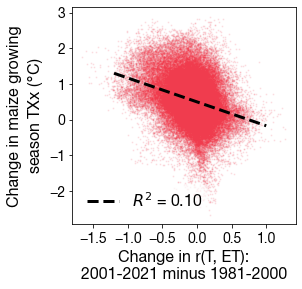

In [62]:
crop = 'maize'

tx_during_tx_chg_binned = data['txx_chg_81_%s_sel_1d'%crop]
r_t_et_chg_binned = data['r_t_et_01_21_%s'%crop]-data['r_t_et_81_01_%s'%crop]

nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)) & (~np.isnan(data['%s_ha_chg'%crop])))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tx_during_tx_chg_binned[nn], X).fit()
residuals = mdl.resid

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned[nn], tx_during_tx_chg_binned[nn], c='#f03c4e', s=1, alpha=.1)
l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xticks([-1.5, -1, -.5, 0, .5, 1])
plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in %s growing\nseason TXx ($\degree$C)'%crop)

legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

# plt.legend(prop={'size': 16}, frameon=False, loc='lower left')

# plt.savefig('chg-txx-vs-r_t_et_chg-gridcell_%s.png'%crop, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
crop = 'maize'

et_during_tx_chg_binned = data['et_on_txx_chg_81_%s_sel_1d'%crop]
r_t_et_chg_binned = data['r_t_et_01_21_%s'%crop]-data['r_t_et_81_01_%s'%crop]

nn = np.where((~np.isnan(et_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)) & (~np.isnan(data['%s_ha_chg'%crop])))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(et_during_tx_chg_binned[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned[nn], et_during_tx_chg_binned[nn], c='#2db566', s=1)
l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xticks([-1.5, -1, -.5, 0, .5, 1])
plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in ET\non %s growing season\nTXx day (Percentile)'%crop)

legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

# plt.legend(prop={'size': 16}, frameon=False, loc='lower left')

# plt.savefig('chg-et-on-txx-vs-r_t_et_chg-gridcell_%s.png'%crop, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
np.corrcoef(sm_during_tx_chg_binned[nn], r_t_et_chg_binned[nn])

In [ ]:
crop = 'maize'


sm_during_tx_chg_binned = data['sm_on_txx_chg_81_%s_sel_1d'%crop]
r_t_et_chg_binned = data['r_t_et_01_21_%s'%crop]-data['r_t_et_81_01_%s'%crop]

nn = np.where((~np.isnan(sm_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)) & (~np.isnan(data['%s_ha_chg'%crop])))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(sm_during_tx_chg_binned[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned[nn], sm_during_tx_chg_binned[nn], c='#db8e30', s=1)

l = '$R^2$ = %.2f'%mdl.rsquared
# l = 'Slope =\n%.1f pp/unit\nr(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label = l)
plt.xticks([-1.5, -1, -.5, 0, .5, 1])

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soil moisture\non %s growing season\nTXx day (Percentile)'%crop)
legend = plt.legend(prop={'size': 16}, frameon=True, loc='lower left')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('none')
legend.get_frame().set_alpha(0.7)

# plt.savefig('chg-sm-on-txx-vs-r_t_et_chg-gridcell_%s.png'%crop, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
plt.plot(sacks_end_by_cf_bin-np.nanmean(sacks_end_by_cf_bin), 'or')
plt.plot(sacks_start_by_cf_bin-np.nanmean(sacks_start_by_cf_bin), 'og')

In [ ]:
r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin[k]-r_t_et_81_01_by_cf_bin[k]) for k in r_t_et_81_01_by_cf_bin.keys()])
plt.plot(cf_bins,r_t_et_chg_binned)

In [ ]:
crop = 'maize'

if crop == 'maize':
    et_during_tx_chg_binned = et_on_txx_chg_81_maize_by_cf_bin
    yield_chg_binned = maize_yield_chg_by_cf_bin
elif crop == 'soy':
    et_during_tx_chg_binned = et_on_txx_chg_81_soy_by_cf_bin
    yield_chg_binned = soy_yield_chg_by_cf_bin
elif crop == 'wheat':
    et_during_tx_chg_binned = et_on_txx_chg_81_wheat_by_cf_bin
    yield_chg_binned = wheat_yield_chg_by_cf_bin



nn = np.where((~np.isnan(et_during_tx_chg_binned)) & (~np.isnan(yield_chg_binned)))[0]

X = sm.add_constant(yield_chg_binned[nn])
mdl = sm.OLS(et_during_tx_chg_binned[nn], X).fit()

x1 = .8
x2 = 1.6

plt.figure(figsize=(4,4))

plt.scatter(yield_chg_binned, et_during_tx_chg_binned, c='#2db566', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f pp/kg/ha'%mdl.params[1]

# plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xlabel('Change in %s yield:\n2001-2016 minus 1981-2000'%crop)
plt.ylabel('Change in ET on\n %s growing season\nTXx day (Percentile)'%crop)
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-et-on-txx-vs-maize_yield_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

crop = 'maize'

if crop == 'maize':
    et_during_tx_chg_binned = et_on_txx_chg_81_maize_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_maize[k]-r_t_et_81_01_by_cf_bin_maize[k]) for k in r_t_et_81_01_by_cf_bin_maize.keys()])
elif crop == 'soy':
    et_during_tx_chg_binned = et_on_txx_chg_81_soy_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_soy[k]-r_t_et_81_01_by_cf_bin_soy[k]) for k in r_t_et_81_01_by_cf_bin_soy.keys()])
elif crop == 'wheat':
    et_during_tx_chg_binned = et_on_txx_chg_81_wheat_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_wheat[k]-r_t_et_81_01_by_cf_bin_wheat[k]) for k in r_t_et_81_01_by_cf_bin_wheat.keys()])


nn = np.where((~np.isnan(et_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(et_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

# padding = 0.5

# # Scatter plot with cmap range extended
# my_vmin = np.min(maize_yield_chg_by_cf_bin) - padding
# my_vmax = np.max(maize_yield_chg_by_cf_bin) + padding
# norm = colors.Normalize(vmin=my_vmin, vmax=my_vmax)
# scatter = plt.scatter(r_t_et_chg_binned, et_during_tx_chg_binned, c=maize_yield_chg_by_cf_bin, 
#                       s=10+cf_bins*100, cmap='Greens', norm=norm)



plt.scatter(r_t_et_chg_binned, et_during_tx_chg_binned, c='#2db566', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f pp/unit\nr(T,ET)'%mdl.params[1]

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in ET on\n %s growing season\nTXx day (Percentile)'%crop)
plt.legend(prop={'size': 14}, frameon=False)

# # Create a new axis for the colorbar
# cax = plt.gcf().add_axes([0.95, 0.125, 0.03, 0.75])  # adjust these values to position your colorbar

# # Create colorbar, with color range limited to actual data
# data_min = np.min(maize_yield_chg_by_cf_bin)
# data_max = np.max(maize_yield_chg_by_cf_bin)
# data_norm = colors.Normalize(vmin=data_min, vmax=data_max)
# cb = colorbar.ColorbarBase(cax, cmap=cm.Greens, norm=data_norm)
# cb.set_label('Change in maize yield\n(2001-2016 minus 1981-2000)')

# plt.savefig('chg-et-on-txx-vs-r_t_et_chg-binned-%s.png'%crop, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
crop = 'maize'

if crop == 'maize':
    sm_during_tx_chg_binned = sm_on_txx_chg_81_maize_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_maize[k]-r_t_et_81_01_by_cf_bin_maize[k]) for k in r_t_et_81_01_by_cf_bin_maize.keys()])
elif crop == 'soy':
    sm_during_tx_chg_binned = sm_on_txx_chg_81_soy_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_soy[k]-r_t_et_81_01_by_cf_bin_soy[k]) for k in r_t_et_81_01_by_cf_bin_soy.keys()])
elif crop == 'wheat':
    sm_during_tx_chg_binned = sm_on_txx_chg_81_wheat_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_wheat[k]-r_t_et_81_01_by_cf_bin_wheat[k]) for k in r_t_et_81_01_by_cf_bin_wheat.keys()])

nn = np.where((~np.isnan(sm_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(sm_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned, sm_during_tx_chg_binned, c='#db8e30', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f pp/unit\nr(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label = l)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soil moisture\non %s growing season\nTXx day (Percentile)'%crop)
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-sm-on-txx-vs-r_t_et_chg-binned-%s.png'%crop, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
crop = 'maize'

if crop == 'maize':
    tx_during_tx_chg_binned = txx_chg_81_maize_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_maize[k]-r_t_et_81_01_by_cf_bin_maize[k]) for k in r_t_et_81_01_by_cf_bin_maize.keys()])
elif crop == 'soy':
    tx_during_tx_chg_binned = txx_chg_81_soy_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_soy[k]-r_t_et_81_01_by_cf_bin_soy[k]) for k in r_t_et_81_01_by_cf_bin_soy.keys()])
elif crop == 'wheat':
    tx_during_tx_chg_binned = txx_chg_81_wheat_by_cf_bin
    r_t_et_chg_binned = np.array([np.nanmean(r_t_et_01_21_by_cf_bin_wheat[k]-r_t_et_81_01_by_cf_bin_wheat[k]) for k in r_t_et_81_01_by_cf_bin_wheat.keys()])

tx_during_tx_chg_binned = txx_chg_81_maize_by_cf_bin

nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

X = sm.add_constant(r_t_et_chg_binned[nn])
mdl = sm.OLS(tx_during_tx_chg_binned[nn], X).fit()

x1 = -.15
x2 = 0.06

plt.figure(figsize=(4,4))

plt.scatter(r_t_et_chg_binned, tx_during_tx_chg_binned, c='#f03c4e', s=10+cf_bins*100)

# l = '$R^2$ = %.2f'%mdl.rsquared
l = 'Slope =\n%.1f$\degree$C/unit r(T,ET)'%mdl.params[1]
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=3, label=l)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in %s growing\nseason TXx ($\degree$C)'%crop)
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-txx-vs-r_t_et_chg-binned-%s.png'%crop, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:

et_on_txx = data['et_on_txx_chg_81_sel_1d']
r_t_et_chg = data['r_t_et_01_21']-data['r_t_et_81_01']

# nn = np.where((~np.isnan(tx_during_tx_chg_binned)) & (~np.isnan(r_t_et_chg_binned)))[0]

bins = np.arange(-1,1,.1)
et_on_txx_binned = np.full(bins.shape,np.nan)

for b,bin in enumerate(bins):
    if b < bins.size-1:
        ind = np.where((r_t_et_chg >= bins[b]) & (r_t_et_chg < bins[b+1]))[0]
        et_on_txx_binned[b] = np.nanmean(et_on_txx[ind])

# plt.savefig('chg-txx-vs-r_t_et_chg-binned.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:
pct = 95
X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['tx_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['tx_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['tx_during_tx_%d_2'%pct]-data['tx_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Tx during Tx (Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-tx-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.plot(cf_bins, tx_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T - tx_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='p = %.2f'%(mdl_3.pvalues[1]))
plt.plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
plt.xlabel('Crop fraction')
plt.ylabel('Change in Tx\non days > %dth percentile\n(Percentile)'%pct)
plt.legend(prop={'size': 18}, frameon=False)

In [ ]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['et_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['et_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['et_during_tx_%d_2'%pct]-data['et_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('ET during Tx (percentile; > 95th)')
ax[0].legend(prop={'size': 14}, frameon=False)


ax[1].plot(cf_bins, et_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-et_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 14}, frameon=False)

In [ ]:
pct = 95

X = sm.add_constant(data['cf'])
mdl_1 = sm.OLS(data['sm_during_tx_%d_1'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_2 = sm.OLS(data['sm_during_tx_%d_2'%pct], X).fit()

X = sm.add_constant(data['cf'])
mdl_3 = sm.OLS(data['sm_during_tx_%d_2'%pct]-data['sm_during_tx_%d_1'%pct], X).fit()

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'ob', markersize=10, label='1981-1999\nslope = %.4f, p = %.2f'%(mdl_1.params[1], mdl_1.pvalues[1]))
ax[0].plot([0, 1], [mdl_1.params[0]+0*mdl_1.params[1], mdl_1.params[0]+1*mdl_1.params[1]], '--b', lw=2)

ax[0].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T, 'or', markersize=10, label='2000-2020\nslope = %.4f, p = %.2f'%(mdl_2.params[1], mdl_2.pvalues[1]))
ax[0].plot([0, 1], [mdl_2.params[0]+0*mdl_2.params[1], mdl_2.params[0]+1*mdl_2.params[1]], '--r', lw=2)

ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('Soil moisture during extreme Tx\n(Tx percentile > %dth)'%pct)
ax[0].legend(prop={'size': 18}, frameon=False)


ax[1].plot(cf_bins, sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T, 'om', markersize=10, label='2000-2020 minus 1981-1999\nslope=%.5f, p = %.2f'%(mdl_3.params[1], mdl_3.pvalues[1]))
ax[1].plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].legend(prop={'size': 18}, frameon=False)

# plt.savefig('chg-sm-during-tx-95-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
pct=95

cur_x = cf_bins
cur_y = sm_during_tx_by_cf_bin_2[np.where(percentiles==pct)[0],:].T-sm_during_tx_by_cf_bin_1[np.where(percentiles==pct)[0],:].T

X = sm.add_constant(cur_x)
mdl_3 = sm.OLS(cur_y, X).fit()

fig = plt.figure(figsize=(4,4))
plt.plot(cur_x, cur_y, 'om', markersize=10, label='p = %.2f'%(mdl_3.pvalues[1]))
plt.plot([0, 1], [mdl_3.params[0]+0*mdl_3.params[1], mdl_3.params[0]+1*mdl_3.params[1]], '--m', lw=2)
plt.xlabel('Crop fraction')
plt.ylabel('Change in soil moisture\non days > %dth percentile\n(Percentile)'%pct)
plt.legend(prop={'size': 18}, frameon=False)

In [ ]:

plt.figure(figsize=(4,4))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.4, -.4], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_61_21_by_cf_bin.keys()):
    m = np.nanmean(r_t_et_61_21_by_cf_bin[k])
    sdev = np.nanstd(r_t_et_61_21_by_cf_bin[k])
    plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m, 'or', markersize=10, label='Mean 1961-2021 r(T, ET)')
    else:
        plt.plot(k, m, 'or', markersize=10)
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('Mean r(T, ET)')
plt.legend(prop={'size': 13}, frameon=False, loc='upper right')

plt.savefig('mean-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
ind = np.where((data['cf']>0))[0]

In [ ]:
r_t_et_chg = data['r_t_et_01_21_maize'][ind] - data['r_t_et_81_01_maize'][ind]

In [ ]:
np.where(r_t_et_chg<-.2)[0].size/r_t_et_chg.size

In [ ]:
np.where(r_t_et_chg<-.1)[0].size/r_t_et_chg.size

In [ ]:
np.where(r_t_et_chg<0)[0].size/r_t_et_chg.size

In [ ]:
plt.figure(figsize=(4,4))
plt.ylim([0, 27000])
plt.xlim([-1.1, 1.1])
plt.hist(r_t_et_chg, color='k', bins=20)
plt.plot([np.nanmedian(r_t_et_chg), np.nanmedian(r_t_et_chg)], [0, 27000], '--r', lw=3, label='Median =\n%0.2f'%np.nanmedian(r_t_et_chg))
plt.xticks([-1, -.5, 0, .5, 1])
plt.xlabel('r(T, ET) change\n(2001-2021 minus 1981-2000)')
plt.ylabel('# cropped grid cells')
plt.legend(fontsize=12, frameon=False)
plt.savefig('chg-r-t-et-cf-hist.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
from scipy.stats import mannwhitneyu


plt.figure(figsize=(4,4))
plt.plot([0,cf_bins.size-.5], [0,0], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.1, -.1], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.2, -.2], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.3, -.3], '--', c='#cccccc')
plt.plot([0,cf_bins.size-.5], [-.4, -.4], '--', c='#cccccc')
for i, k in  enumerate(r_t_et_61_81_by_cf_bin.keys()):
    m1 = np.nanmean(r_t_et_61_81_by_cf_bin[k])
    sdev1 = np.nanstd(r_t_et_81_01_by_cf_bin_maize[k])
    
    m2 = np.nanmean(r_t_et_81_01_by_cf_bin_maize[k])
    sdev2 = np.nanstd(r_t_et_81_01_by_cf_bin_maize[k])
    
    m3 = np.nanmean(r_t_et_01_21_by_cf_bin_maize[k])
    sdev3 = np.nanstd(r_t_et_01_21_by_cf_bin_maize[k])
    
#     t1,p1 = st.ks_2samp(r_t_et_61_81_by_cf_bin[k], r_t_et_81_01_by_cf_bin_maize[k])
#     t2,p2 = st.ks_2samp(r_t_et_81_01_by_cf_bin_maize[k], r_t_et_01_21_by_cf_bin_maize[k])
    
    nn = np.where((~np.isnan(r_t_et_61_81_by_cf_bin[k])) & (~np.isnan(r_t_et_81_01_by_cf_bin_maize[k])) & (~np.isnan(r_t_et_01_21_by_cf_bin_maize[k])))[0]
    
    t1,p1 = st.ttest_ind(r_t_et_61_81_by_cf_bin[k][nn], r_t_et_81_01_by_cf_bin_maize[k][nn])
    t2,p2 = st.ttest_ind(r_t_et_81_01_by_cf_bin_maize[k][nn], r_t_et_01_21_by_cf_bin_maize[k][nn])
    
    
    print(k, p1, p2)
#     plt.plot([k,k], [m-sdev, m+sdev], c='k')
    if i == 0:
        plt.plot(k, m1, 'og', markersize=10, label='1961-1980')
        if p1 < 0.05:
            plt.plot(k, m2, 'ob', markersize=10, label='1981-2000')
        else:
            plt.plot(k, m2, 'ob', markersize=10, label='1981-2000', fillstyle='none')
            
        
        if p2 < 0.01:
            plt.plot(k, m3, 'or', markersize=10, label='2001-2021', alpha=1)
        elif p2 < 0.05:
            plt.plot(k, m3, 'or', markersize=10, label='2001-2021', alpha=.5)
        else: 
            plt.plot(k, m3, 'or', markersize=10, label='2001-2021', fillstyle='none')
        
    plt.plot(k, m1, 'og', markersize=10)
    
    if p1 < 0.01:
        plt.plot(k, m2, 'ob', markersize=10, alpha=1)
    elif p1 < 0.05:
        plt.plot(k, m2, 'ob', markersize=10, alpha=.5)
    else:
        plt.plot(k, m2, 'ob', markersize=10, fillstyle='none')
        
    if p2 < 0.01:
        plt.plot(k, m3, 'or', markersize=10, alpha=1)
    elif p2 < 0.05:
        plt.plot(k, m3, 'or', markersize=10, alpha=.5)
    else:
        plt.plot(k, m3, 'or', markersize=10, fillstyle='none')
    
plt.gca().set_xticks(range(0,cf_bins.size,2))
plt.gca().set_xticklabels(np.round(cf_bins[np.arange(0,cf_bins.size,2)],2))
plt.xlabel('Crop fraction')
plt.ylabel('Mean r(T, ET)')
plt.legend(prop={'size': 14}, frameon=False, loc='upper right')

plt.savefig('chg-r-t-et-by-cf.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [31]:
# tx_during_tx_95_iizumi = era5_txx.tasmax_grow_max.values[:, lat_ind_sel, :]
tx_during_tx_95_iizumi_maize = era5_tmean_maize.t_mean.values[:, lat_ind_sel, :]
tx_during_tx_95_iizumi_soy = era5_tmean_soy.tasmax_grow_mean.values[:, lat_ind_sel, :]
tx_during_tx_95_iizumi_wheat = era5_tmean_wheat.tasmax_grow_mean.values[:, lat_ind_sel, :]

In [32]:

iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid['var'].values
iizumi_maize_ds_regrid_values[iizumi_maize_ds_regrid_values==0] = np.nan
iizumi_maize_ds_regrid_values = iizumi_maize_ds_regrid_values[:,lat_ind_sel,:]
iizumi_maize_ds_regrid_values_1d = np.nanmean(iizumi_maize_ds_regrid_values, axis=0)
iizumi_maize_ds_regrid_values_1d = np.reshape(iizumi_maize_ds_regrid_values_1d, [iizumi_maize_ds_regrid_values_1d.size,1])

iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid['var'].values
iizumi_soy_ds_regrid_values[iizumi_soy_ds_regrid_values==0] = np.nan
iizumi_soy_ds_regrid_values = iizumi_soy_ds_regrid_values[:, lat_ind_sel, :]
iizumi_soy_ds_regrid_values_1d = np.nanmean(iizumi_soy_ds_regrid_values, axis=0)
iizumi_soy_ds_regrid_values_1d = np.reshape(iizumi_soy_ds_regrid_values_1d, [iizumi_soy_ds_regrid_values_1d.size,1])

iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid['var'].values
iizumi_wheat_ds_regrid_values[iizumi_wheat_ds_regrid_values==0] = np.nan
iizumi_wheat_ds_regrid_values = iizumi_wheat_ds_regrid_values[:, lat_ind_sel, :]
iizumi_wheat_ds_regrid_values_1d = np.nanmean(iizumi_wheat_ds_regrid_values, axis=0)
iizumi_wheat_ds_regrid_values_1d = np.reshape(iizumi_wheat_ds_regrid_values_1d, [iizumi_wheat_ds_regrid_values_1d.size,1])


maize_ha_regrid_2005_sel = maize_ha_regrid_2005[lat_ind_sel,:]
maize_ha_regrid_2005_sel_1d = maize_ha_regrid_2005_sel.reshape([maize_ha_regrid_2005_sel.size,1])

soy_ha_regrid_2005_sel = soy_ha_regrid_2005[lat_ind_sel,:]
soy_ha_regrid_2005_sel_1d = soy_ha_regrid_2005_sel.reshape([soy_ha_regrid_2005_sel.size,1])

wheat_ha_regrid_2005_sel = wheat_ha_regrid_2005[lat_ind_sel,:]
wheat_ha_regrid_2005_sel_1d = wheat_ha_regrid_2005_sel.reshape([wheat_ha_regrid_2005_sel.size,1])

In [ ]:
import numpy as np
from pyts.decomposition import SingularSpectrumAnalysis

# Your data
x_range = np.arange(1981, 2016+1)
y_range = np.nanmean(np.nanmean(iizumi_maize_ds_regrid['var'].values, axis=2), axis=1)

# Reshape the time series for the SSA algorithm: [n_samples, n_timestamps]
y_range_reshape = np.reshape(y_range, (1, -1))

# Singular Spectrum Analysis parameters
window_size = 15  # The length of each reconstructed subseries
groups = [np.arange(i, i + 5) for i in range(0, 10, 5)]  # Example grouping of eigenmodes to reconstruct the trend

# Apply Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
y_ssa = ssa.fit_transform(y_range_reshape)

trend = y_ssa[0]

Text(0.5, 1.0, 'Soy')

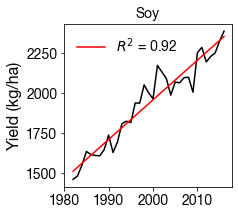

In [33]:
from pyts.decomposition import SingularSpectrumAnalysis


x_range = np.arange(1982, 2016+1)
y_range = np.nanmean(np.nanmean(iizumi_soy_ds_regrid['var'].values[1:]*1000, axis=2), axis=1)

X = sm.add_constant(x_range)
mdl = sm.OLS(y_range, X).fit()

plt.figure(figsize=(3,3))
plt.plot(x_range, y_range, 'k')
plt.plot([x_range[0], x_range[-1]], [mdl.params[0]+mdl.params[1]*x_range[0], mdl.params[0]+mdl.params[1]*x_range[-1]], 'r', label='$R^2$ = %.2f'%mdl.rsquared)
plt.ylabel('Yield (kg/ha)')
plt.xticks([1980, 1990, 2000, 2010])
plt.legend(frameon=False, fontsize=14)
plt.title('Soy', fontsize=14)
# plt.savefig('soy-yield-global-trend.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [34]:
from scipy import signal
from pyts.decomposition import SingularSpectrumAnalysis

use_ssa = False

maize_yield_txx_sensitivity = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_yield_txx_sensitivity = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_yield_txx_sensitivity = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

maize_yield_txx_sensitivity_nonsd = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_yield_txx_sensitivity_nonsd = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_yield_txx_sensitivity_nonsd = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

for xlim in range(tx_during_tx_95_iizumi_maize.shape[1]):
    if xlim%50==0: print(xlim)
    for ylim in range(tx_during_tx_95_iizumi_maize.shape[2]):
        
        txx_ts = tx_during_tx_95_iizumi_maize[:,xlim,ylim]
        
        maize_yield_ts = iizumi_maize_ds_regrid_values[:,xlim,ylim]
        soy_yield_ts = iizumi_soy_ds_regrid_values[:,xlim,ylim]
        wheat_yield_ts = iizumi_wheat_ds_regrid_values[:,xlim,ylim]
        
        nn = np.where((~np.isnan(txx_ts)) & (~np.isnan(maize_yield_ts)))[0]
        
        if nn.size >= 30:
            # standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])/np.nanstd(txx_ts)
            
            if use_ssa:
                
                # Reshape the time series for the SSA algorithm: [n_samples, n_timestamps]
                maize_yield_ts_reshape = np.reshape(maize_yield_ts[nn], (1, -1))

                # Singular Spectrum Analysis parameters
                window_size = 15  # The length of each reconstructed subseries
                groups = [np.arange(i, i + 5) for i in range(0, 10, 5)]  # Example grouping of eigenmodes to reconstruct the trend

                # Apply Singular Spectrum Analysis
                ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
                trend = ssa.fit_transform(maize_yield_ts_reshape)
                maize_yield_ts_detrend = maize_yield_ts[nn] - trend[0][0,:]
                
                maize_yield_ts_detrend = maize_yield_ts_detrend/np.nanstd(maize_yield_ts)
            else:
                maize_yield_ts_detrend = signal.detrend(maize_yield_ts[nn])/np.nanstd(maize_yield_ts)
            
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(maize_yield_ts_detrend, X).fit()
            maize_yield_txx_sensitivity[xlim, ylim] = mdl.params[1]
            
            # non standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])
            maize_yield_ts_detrend = signal.detrend(maize_yield_ts[nn])
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(maize_yield_ts_detrend, X).fit()
            maize_yield_txx_sensitivity_nonsd[xlim, ylim] = mdl.params[1]
        
        txx_ts = tx_during_tx_95_iizumi_soy[:,xlim,ylim]
        nn = np.where((~np.isnan(txx_ts)) & (~np.isnan(soy_yield_ts)))[0]
        
        if nn.size >= 30:
            # standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])/np.nanstd(txx_ts)
            
            if use_ssa:
                
                # Reshape the time series for the SSA algorithm: [n_samples, n_timestamps]
                soy_yield_ts_reshape = np.reshape(soy_yield_ts[nn], (1, -1))

                # Singular Spectrum Analysis parameters
                window_size = 15  # The length of each reconstructed subseries
                groups = [np.arange(i, i + 5) for i in range(0, 10, 5)]  # Example grouping of eigenmodes to reconstruct the trend

                # Apply Singular Spectrum Analysis
                ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
                trend = ssa.fit_transform(soy_yield_ts_reshape)
                soy_yield_ts_detrend = soy_yield_ts[nn] - trend[0][0,:]
                
                soy_yield_ts_detrend = soy_yield_ts_detrend/np.nanstd(soy_yield_ts)
            else:
                soy_yield_ts_detrend = signal.detrend(soy_yield_ts[nn])/np.nanstd(soy_yield_ts)
            
            
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(soy_yield_ts_detrend, X).fit()
            soy_yield_txx_sensitivity[xlim, ylim] = mdl.params[1]
            
            # non standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])
            soy_yield_ts_detrend = signal.detrend(soy_yield_ts[nn])
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(soy_yield_ts_detrend, X).fit()
            soy_yield_txx_sensitivity_nonsd[xlim, ylim] = mdl.params[1]
            
        
        txx_ts = tx_during_tx_95_iizumi_wheat[:,xlim,ylim]
        nn = np.where((~np.isnan(txx_ts)) & (~np.isnan(wheat_yield_ts)))[0]
        
        if nn.size >= 30:
            # standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])/np.nanstd(txx_ts)
            
            
            if use_ssa:
                
                # Reshape the time series for the SSA algorithm: [n_samples, n_timestamps]
                wheat_yield_ts_reshape = np.reshape(wheat_yield_ts[nn], (1, -1))

                # Singular Spectrum Analysis parameters
                window_size = 15  # The length of each reconstructed subseries
                groups = [np.arange(i, i + 5) for i in range(0, 10, 5)]  # Example grouping of eigenmodes to reconstruct the trend

                # Apply Singular Spectrum Analysis
                ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
                trend = ssa.fit_transform(wheat_yield_ts_reshape)
                wheat_yield_ts_detrend = wheat_yield_ts[nn] - trend[0][0,:]
                
                wheat_yield_ts_detrend = wheat_yield_ts_detrend/np.nanstd(wheat_yield_ts)
            else:
                wheat_yield_ts_detrend = signal.detrend(wheat_yield_ts[nn])/np.nanstd(wheat_yield_ts)
            
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(wheat_yield_ts_detrend, X).fit()
            wheat_yield_txx_sensitivity[xlim, ylim] = mdl.params[1]
            
            # non standardized
            txx_ts_detrend = signal.detrend(txx_ts[nn])
            wheat_yield_ts_detrend = signal.detrend(wheat_yield_ts[nn])
            X = sm.add_constant(txx_ts_detrend)
            mdl = sm.OLS(wheat_yield_ts_detrend, X).fit()
            wheat_yield_txx_sensitivity_nonsd[xlim, ylim] = mdl.params[1]
        

0
50
100
150
200
250
300
350
400
450
500


In [45]:
cf_cutoff = 10

irr_below = True
irr_cutoff = 200

if irr_below:
    nn_maize = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
                  (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d > 0) & (crop_ha_regrid_sel_1d < cf_cutoff) & \
                    (maize_ha_regrid_2005_sel_1d > 0) & (irrigationData_regrid_sel_1d < irr_cutoff))[0]
else:
    nn_maize = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
                  (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d > 0) & (crop_ha_regrid_sel_1d < cf_cutoff) & \
                    (maize_ha_regrid_2005_sel_1d > 0) & (irrigationData_regrid_sel_1d > irr_cutoff))[0]

maize_yield_txx_sensitivity_sel_1d = maize_yield_txx_sensitivity.reshape([maize_yield_txx_sensitivity.size,1])
maize_yield_txx_sensitivity_sel_1d = maize_yield_txx_sensitivity_sel_1d[nn_maize]

maize_yield_txx_sensitivity_nonsd_sel_1d = maize_yield_txx_sensitivity_nonsd.reshape([maize_yield_txx_sensitivity_nonsd.size,1])
maize_yield_txx_sensitivity_nonsd_sel_1d = maize_yield_txx_sensitivity_nonsd_sel_1d[nn_maize]

if irr_below:
    nn_soy = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
                  (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d > 0) & (crop_ha_regrid_sel_1d < cf_cutoff) & \
                      (soy_ha_regrid_2005_sel_1d > 0) & (irrigationData_regrid_sel_1d < irr_cutoff))[0]
else:
    nn_soy = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
                  (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d > 0) & (crop_ha_regrid_sel_1d < cf_cutoff) & \
                      (soy_ha_regrid_2005_sel_1d > 0) & (irrigationData_regrid_sel_1d > irr_cutoff))[0]

soy_yield_txx_sensitivity_sel_1d = soy_yield_txx_sensitivity.reshape([soy_yield_txx_sensitivity.size,1])
soy_yield_txx_sensitivity_sel_1d = soy_yield_txx_sensitivity_sel_1d[nn_soy]

soy_yield_txx_sensitivity_nonsd_sel_1d = soy_yield_txx_sensitivity_nonsd.reshape([soy_yield_txx_sensitivity_nonsd.size,1])
soy_yield_txx_sensitivity_nonsd_sel_1d = soy_yield_txx_sensitivity_nonsd_sel_1d[nn_soy]

if irr_below:
    nn_wheat = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
                  (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d > 0) & (crop_ha_regrid_sel_1d < cf_cutoff) & \
                        (wheat_ha_regrid_2005_sel_1d > 0) & (irrigationData_regrid_sel_1d < irr_cutoff))[0]
else:
    nn_wheat = np.where((~np.isnan(tmean_chg_81_sel_1d)) & \
                  (~np.isnan(crop_ha_regrid_sel_1d)) & (crop_ha_regrid_sel_1d > 0) & (crop_ha_regrid_sel_1d < cf_cutoff) & \
                        (wheat_ha_regrid_2005_sel_1d > 0) & (irrigationData_regrid_sel_1d > irr_cutoff))[0]

wheat_yield_txx_sensitivity_sel_1d = wheat_yield_txx_sensitivity.reshape([wheat_yield_txx_sensitivity.size,1])
wheat_yield_txx_sensitivity_sel_1d = wheat_yield_txx_sensitivity_sel_1d[nn_wheat]

wheat_yield_txx_sensitivity_nonsd_sel_1d = wheat_yield_txx_sensitivity_nonsd.reshape([wheat_yield_txx_sensitivity_nonsd.size,1])
wheat_yield_txx_sensitivity_nonsd_sel_1d = wheat_yield_txx_sensitivity_nonsd_sel_1d[nn_wheat]



In [46]:

nn_reg_maize = np.where((~np.isnan(t_et_81_16_1d[nn_maize])) & (~np.isnan(crop_ha_regrid_sel_1d[nn_maize])) & (~np.isnan(maize_yield_txx_sensitivity_sel_1d)))[0]

import statsmodels.api as sm
import pandas as pd

# Convert your existing arrays to DataFrames, naming the columns
df1 = pd.DataFrame(t_et_81_16_1d[nn_maize][nn_reg_maize], columns=['r(T, ET)'])
df2 = pd.DataFrame(crop_ha_regrid_sel_1d[nn_maize][nn_reg_maize], columns=['CF'])  # Replace `new_var` with your actual second variable

# Concatenate the two DataFrames along axis=1 (i.e., horizontally)
X_combined_df = pd.concat([df1, df2], axis=1)

# Add a constant column for the intercept
X = sm.add_constant(X_combined_df)

# For the second model
mdl_maize = sm.OLS(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], X).fit()

# Summary of the model
mdl_maize.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     5285.
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:57:55   Log-Likelihood:                 5069.2
No. Observations:               33365   AIC:                        -1.013e+04
Df Residuals:                   33362   BIC:                        -1.011e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0214      0.002    -12.867      0.000      -0.025      -0.018
r(T, ET)       0.2198      0.002     96.356      0.000       0.215       0.224
CF            -0.1031      0.005    -22.854      0.000      -0.112      -0.094
==============================================================================
Omnibus:                     1818.267   Durbin-Watson:                   0.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5296.285
Skew:                          -0.266   Prob(JB):                         0.00
Kurtosis:                       4.878   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:

nn_reg_maize = np.where((~np.isnan(t_et_81_16_1d[nn_maize])) & (~np.isnan(maize_yield_txx_sensitivity_sel_1d)))[0]

X = sm.add_constant(t_et_81_16_1d[nn_maize][nn_reg_maize])
mdl_maize_nonsd = sm.OLS(maize_yield_txx_sensitivity_nonsd_sel_1d[nn_reg_maize], X).fit()

X = sm.add_constant(t_et_81_16_1d[nn_maize][nn_reg_maize])
mdl_maize = sm.OLS(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], X).fit()
mdl_maize.summary()


# nn3_maize = np.where((~np.isnan(data['r_t_et_81_16'][nn2_maize])) & (~np.isnan(maize_yield_txx_sensitivity_sel_1d)))[0]

# X = sm.add_constant(data['r_t_et_81_16'][nn2_maize][nn3_maize])
# mdl_maize_nonsd = sm.OLS(maize_yield_txx_sensitivity_nonsd_sel_1d[nn3_maize], X).fit()

# X = sm.add_constant(data['r_t_et_81_16'][nn2_maize][nn3_maize])
# mdl_maize = sm.OLS(maize_yield_txx_sensitivity_sel_1d[nn3_maize], X).fit()
# mdl_maize.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     9893.
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:57:57   Log-Likelihood:                 4810.0
No. Observations:               33365   AIC:                            -9616.
Df Residuals:                   33363   BIC:                            -9599.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0468      0.001    -37.576      0.000      -0.049      -0.044
x1             0.2266      0.002     99.463      0.000       0.222       0.231
==============================================================================
Omnibus:                     1907.100   Durbin-Watson:                   0.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5837.866
Skew:                          -0.266   Prob(JB):                         0.00
Kurtosis:                       4.979   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized maize yield\nsensitivity to growing season\nmean Tx (SD/$\\degree$C)')

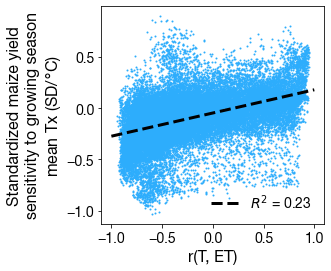

In [48]:
plt.figure(figsize=(4,4))
x1 = -1
x2 = 1
plt.scatter(t_et_81_16_1d[nn_maize][nn_reg_maize], maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], c='#2dadfc', s=1)
plt.plot([x1, x2], [mdl_maize.params[0]+mdl_maize.params[1]*x1, mdl_maize.params[0]+mdl_maize.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl_maize.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('r(T, ET)')
plt.ylabel('Standardized maize yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('maize-yield-sens-rt-et-high-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

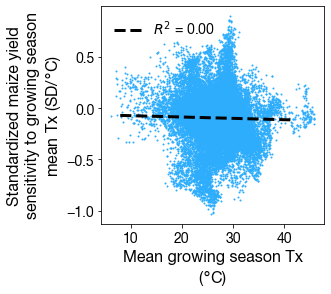

In [61]:
mean_tx_maize = np.nanmean(tx_during_tx_95_iizumi_maize, axis=0)
mean_tx_maize_1d = mean_tx_maize.reshape([mean_tx_maize.size])

X = sm.add_constant(mean_tx_maize_1d[nn_maize][nn_reg_maize])
mdl = sm.OLS(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], X).fit()
# nn = np.where((~np.isnan(mean_tx_maize_1d)) & (~np.isnan(maize_yield_txx_sensitivity.reshape([maize_yield_txx_sensitivity.size]))))[0]
# X = sm.add_constant(mean_tx_maize_1d[nn])
# mdl = sm.OLS(maize_yield_txx_sensitivity.reshape([maize_yield_txx_sensitivity.size])[nn], X).fit()

x1 = 8
x2 = 42
plt.figure(figsize=(4,4))
plt.scatter(mean_tx_maize_1d[nn_maize][nn_reg_maize], maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], c='#2dadfc', s=1)
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('Mean growing season Tx\n($\degree$C)')
plt.ylabel('Standardized maize yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('maize-yield-sens-vs-mean-tx.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [50]:

nn_reg_soy = np.where((~np.isnan(t_et_81_16_soy_1d[nn_soy])) & (~np.isnan(soy_yield_txx_sensitivity_sel_1d)))[0]

X = sm.add_constant(t_et_81_16_soy_1d[nn_soy][nn_reg_soy])
mdl_soy_nonsd = sm.OLS(soy_yield_txx_sensitivity_nonsd_sel_1d[nn_reg_soy], X).fit()

X = sm.add_constant(t_et_81_16_soy_1d[nn_soy][nn_reg_soy])
mdl_soy = sm.OLS(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], X).fit()
mdl_soy.summary()


# nn3_soy = np.where((~np.isnan(data['r_t_et_81_16_soy'][nn2_soy])) & (~np.isnan(soy_yield_txx_sensitivity_sel_1d)))[0]

# X = sm.add_constant(data['r_t_et_81_16_soy'][nn2_soy][nn3_soy])
# mdl_soy_nonsd = sm.OLS(soy_yield_txx_sensitivity_nonsd_sel_1d[nn3_soy], X).fit()

# X = sm.add_constant(data['r_t_et_81_16_soy'][nn2_soy][nn3_soy])
# mdl_soy = sm.OLS(soy_yield_txx_sensitivity_sel_1d[nn3_soy], X).fit()
# mdl_soy.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                 1.182e+04
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:58:07   Log-Likelihood:                 3077.4
No. Observations:               14472   AIC:                            -6151.
Df Residuals:                   14470   BIC:                            -6136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0458      0.002    -28.047      0.000      -0.049      -0.043
x1             0.3296      0.003    108.707      0.000       0.324       0.336
==============================================================================
Omnibus:                       63.881   Durbin-Watson:                   0.207
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.289
Skew:                           0.145   Prob(JB):                     4.03e-15
Kurtosis:                       3.160   Cond. No.                         1.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized soy yield\nsensitivity to growing season\nmean Tx (SD/$\\degree$C)')

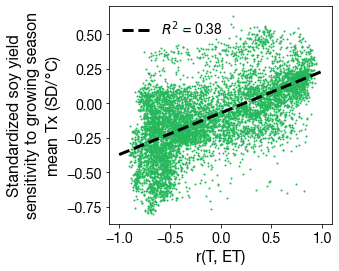

In [309]:
plt.figure(figsize=(4,4))
x1 = -1
x2 = 1
plt.scatter(t_et_81_16_soy_1d[nn_soy][nn_reg_soy], soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], c='#25b85b', s=1)
plt.plot([x1, x2], [mdl_soy.params[0]+mdl_soy.params[1]*x1, mdl_soy.params[0]+mdl_soy.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl_soy.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('r(T, ET)')
plt.ylabel('Standardized soy yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('soy-yield-sens-rt-et-high-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

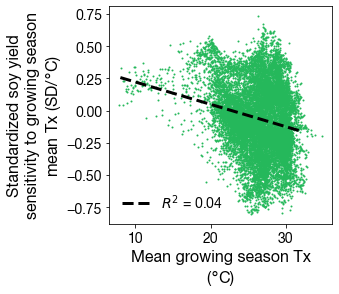

In [60]:
mean_tx_soy = np.nanmean(tx_during_tx_95_iizumi_soy, axis=0)
mean_tx_soy_1d = mean_tx_soy.reshape([mean_tx_soy.size])

X = sm.add_constant(mean_tx_soy_1d[nn_soy][nn_reg_soy])
mdl = sm.OLS(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], X).fit()
# nn = np.where((~np.isnan(mean_tx_soy_1d)) & (~np.isnan(soy_yield_txx_sensitivity.reshape([soy_yield_txx_sensitivity.size]))))[0]
# X = sm.add_constant(mean_tx_soy_1d[nn])
# mdl = sm.OLS(soy_yield_txx_sensitivity.reshape([soy_yield_txx_sensitivity.size])[nn], X).fit()

x1 = 8
x2 = 32
plt.figure(figsize=(4,4))
plt.scatter(mean_tx_soy_1d[nn_soy][nn_reg_soy], soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], c='#25b85b', s=1)
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('Mean growing season Tx\n($\degree$C)')
plt.ylabel('Standardized soy yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('soy-yield-sens-vs-mean-tx.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [54]:
nn_reg_wheat = np.where((~np.isnan(t_et_81_16_wheat_1d[nn_wheat])) & (~np.isnan(wheat_yield_txx_sensitivity_sel_1d)))[0]

X = sm.add_constant(t_et_81_16_wheat_1d[nn_wheat][nn_reg_wheat])
mdl_wheat_nonsd = sm.OLS(wheat_yield_txx_sensitivity_nonsd_sel_1d[nn_reg_wheat], X).fit()

X = sm.add_constant(t_et_81_16_wheat_1d[nn_wheat][nn_reg_wheat])
mdl_wheat = sm.OLS(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], X).fit()
mdl_wheat.summary()



# nn3_wheat = np.where((~np.isnan(data['r_t_et_81_16_wheat'][nn2_wheat])) & (~np.isnan(wheat_yield_txx_sensitivity_sel_1d)))[0]

# X = sm.add_constant(data['r_t_et_81_16_wheat'][nn2_wheat][nn3_wheat])
# mdl_wheat_nonsd = sm.OLS(wheat_yield_txx_sensitivity_nonsd_sel_1d[nn3_wheat], X).fit()

# X = sm.add_constant(data['r_t_et_81_16_wheat'][nn2_wheat][nn3_wheat])
# mdl_wheat = sm.OLS(wheat_yield_txx_sensitivity_sel_1d[nn3_wheat], X).fit()
# mdl_wheat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     3181.
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:59:15   Log-Likelihood:                 1674.2
No. Observations:               25172   AIC:                            -3344.
Df Residuals:                   25170   BIC:                            -3328.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1067      0.002    -67.932      0.000      -0.110      -0.104
x1             0.1675      0.003     56.399      0.000       0.162       0.173
==============================================================================
Omnibus:                      334.535   Durbin-Watson:                   0.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.322
Skew:                          -0.170   Prob(JB):                     1.09e-57
Kurtosis:                       2.632   Cond. No.                         2.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized wheat yield\nsensitivity to growing season\nmean Tx (SD/$\\degree$C)')

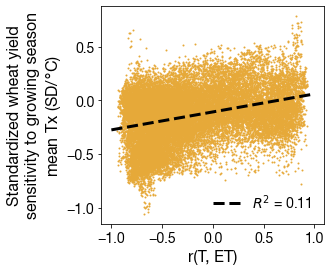

In [55]:
plt.figure(figsize=(4,4))
x1 = -1
x2 = 1
plt.scatter(t_et_81_16_wheat_1d[nn_wheat][nn_reg_wheat], wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], c='#e6a939', s=1)
plt.plot([x1, x2], [mdl_wheat.params[0]+mdl_wheat.params[1]*x1, mdl_wheat.params[0]+mdl_wheat.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl_wheat.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('r(T, ET)')
plt.ylabel('Standardized wheat yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('wheat-yield-sens-rt-et-high-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

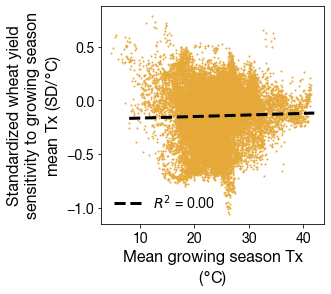

In [59]:
mean_tx_wheat = np.nanmean(tx_during_tx_95_iizumi_wheat, axis=0)
mean_tx_wheat_1d = mean_tx_wheat.reshape([mean_tx_wheat.size])

X = sm.add_constant(mean_tx_wheat_1d[nn_wheat][nn_reg_wheat])
mdl = sm.OLS(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], X).fit()
# nn = np.where((~np.isnan(mean_tx_wheat_1d)) & (~np.isnan(wheat_yield_txx_sensitivity.reshape([wheat_yield_txx_sensitivity.size]))))[0]
# X = sm.add_constant(mean_tx_wheat_1d[nn])
# mdl = sm.OLS(wheat_yield_txx_sensitivity.reshape([wheat_yield_txx_sensitivity.size])[nn], X).fit()

x1 = 8
x2 = 42
plt.figure(figsize=(4,4))
plt.scatter(mean_tx_wheat_1d[nn_wheat][nn_reg_wheat], wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], c='#e6a939', s=1)
plt.plot([x1, x2], [mdl.params[0]+mdl.params[1]*x1, mdl.params[0]+mdl.params[1]*x2], '--k', lw=3, label='$R^2$ = %.2f'%(mdl.rsquared))
plt.legend(prop={'size': 14}, frameon=False)
plt.xlabel('Mean growing season Tx\n($\degree$C)')
plt.ylabel('Standardized wheat yield\nsensitivity to growing season\nmean Tx (SD/$\degree$C)')
# plt.savefig('wheat-yield-sens-vs-mean-tx.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [314]:

r_t_et_1_maize = t_et_81_01_1d[nn_maize][nn_reg_maize]
r_t_et_2_maize = t_et_01_21_1d[nn_maize][nn_reg_maize]

# r_t_et_1_maize = data['r_t_et_81_01_maize'][nn2_maize][nn3_maize]
# r_t_et_2_maize = data['r_t_et_01_21_maize'][nn2_maize][nn3_maize]

r_t_et_chg_maize = t_et_01_21_1d[nn_maize][nn_reg_maize]-t_et_81_01_1d[nn_maize][nn_reg_maize]

r_t_et_1_maize_low = np.nanpercentile(r_t_et_1_maize, 25)
r_t_et_1_maize_mid = np.nanpercentile(r_t_et_1_maize, 50)
r_t_et_1_maize_high = np.nanpercentile(r_t_et_1_maize, 75)

r_t_et_2_maize_low = np.nanpercentile(r_t_et_2_maize, 25)
r_t_et_2_maize_mid = np.nanpercentile(r_t_et_2_maize, 50)
r_t_et_2_maize_high = np.nanpercentile(r_t_et_2_maize, 75)

r_t_et_chg_maize_low = np.nanpercentile(r_t_et_chg_maize, 25)
r_t_et_chg_maize_mid = np.nanpercentile(r_t_et_chg_maize, 50)
r_t_et_chg_maize_high = np.nanpercentile(r_t_et_chg_maize, 75)

r_t_et_chg_maize_val = np.nanpercentile(r_t_et_2_maize, 50) - np.nanpercentile(r_t_et_1_maize, 50)
r_t_et_chg_maize_pct = (-1+np.nanmean(r_t_et_1_maize)/np.nanmean(r_t_et_2_maize))*100

yield_chg_maize = iizumi_maize_ds_regrid_values_2_1d[nn_maize][nn_reg_maize]-iizumi_maize_ds_regrid_values_1_1d[nn_maize][nn_reg_maize]
# yield_chg_maize = data['maize_yield_2'][nn2_maize][nn3_maize]-data['maize_yield_1'][nn2_maize][nn3_maize]



r_t_et_1_soy = t_et_81_01_soy_1d[nn_soy][nn_reg_soy]
r_t_et_2_soy = t_et_01_21_soy_1d[nn_soy][nn_reg_soy]

# r_t_et_1_soy = data['r_t_et_81_01_soy'][nn2_soy][nn3_soy]
# r_t_et_2_soy = data['r_t_et_01_21_soy'][nn2_soy][nn3_soy]

r_t_et_chg_soy = t_et_01_21_soy_1d[nn_soy][nn_reg_soy]-t_et_81_01_soy_1d[nn_soy][nn_reg_soy]
yield_chg_soy = iizumi_soy_ds_regrid_values_2_1d[nn_soy][nn_reg_soy]-iizumi_soy_ds_regrid_values_1_1d[nn_soy][nn_reg_soy]
# yield_chg_soy = data['soy_yield_2'][nn2_soy][nn3_soy]-data['soy_yield_1'][nn2_soy][nn3_soy]

r_t_et_1_soy_low = np.nanpercentile(r_t_et_1_soy, 25)
r_t_et_1_soy_mid = np.nanpercentile(r_t_et_1_soy, 50)
r_t_et_1_soy_high = np.nanpercentile(r_t_et_1_soy, 75)

r_t_et_2_soy_low = np.nanpercentile(r_t_et_2_soy, 25)
r_t_et_2_soy_mid = np.nanpercentile(r_t_et_2_soy, 50)
r_t_et_2_soy_high = np.nanpercentile(r_t_et_2_soy, 75)

r_t_et_chg_soy_low = np.nanpercentile(r_t_et_chg_soy, 25)
r_t_et_chg_soy_mid = np.nanpercentile(r_t_et_chg_soy, 50)
r_t_et_chg_soy_high = np.nanpercentile(r_t_et_chg_soy, 75)

r_t_et_chg_soy_val = np.nanpercentile(r_t_et_2_soy,50) - np.nanpercentile(r_t_et_1_soy,50)
r_t_et_chg_soy_pct = (-1+np.nanmean(r_t_et_1_soy)/np.nanmean(r_t_et_2_soy))*100







r_t_et_1_wheat = t_et_81_01_wheat_1d[nn_wheat][nn_reg_wheat]
r_t_et_2_wheat = t_et_01_21_wheat_1d[nn_wheat][nn_reg_wheat]

# r_t_et_1_wheat = data['r_t_et_81_01_wheat'][nn2_wheat][nn3_wheat]
# r_t_et_2_wheat = data['r_t_et_01_21_wheat'][nn2_wheat][nn3_wheat]

r_t_et_chg_wheat = t_et_01_21_wheat_1d[nn_wheat][nn_reg_wheat]-t_et_81_01_wheat_1d[nn_wheat][nn_reg_wheat]
yield_chg_wheat = iizumi_wheat_ds_regrid_values_2_1d[nn_wheat][nn_reg_wheat]-iizumi_wheat_ds_regrid_values_1_1d[nn_wheat][nn_reg_wheat]
# yield_chg_wheat = data['wheat_yield_2'][nn2_wheat][nn3_wheat]-data['wheat_yield_1'][nn2_wheat][nn3_wheat]

r_t_et_1_wheat_low = np.nanpercentile(r_t_et_1_wheat, 25)
r_t_et_1_wheat_mid = np.nanpercentile(r_t_et_1_wheat, 50)
r_t_et_1_wheat_high = np.nanpercentile(r_t_et_1_wheat, 75)

r_t_et_2_wheat_low = np.nanpercentile(r_t_et_2_wheat, 25)
r_t_et_2_wheat_mid = np.nanpercentile(r_t_et_2_wheat, 50)
r_t_et_2_wheat_high = np.nanpercentile(r_t_et_2_wheat, 75)

r_t_et_chg_wheat_low = np.nanpercentile(r_t_et_chg_wheat, 25)
r_t_et_chg_wheat_mid = np.nanpercentile(r_t_et_chg_wheat, 50)
r_t_et_chg_wheat_high = np.nanpercentile(r_t_et_chg_wheat, 75)

r_t_et_chg_wheat_val = np.nanpercentile(r_t_et_2_wheat,50)-np.nanpercentile(r_t_et_1_wheat,50)
r_t_et_chg_wheat_pct = (-1+np.nanmean(r_t_et_1_wheat)/np.nanmean(r_t_et_2_wheat))*100


In [315]:
maize_yield_txx_sensitivity_chg = mdl_maize.params[1]*r_t_et_chg_maize
soy_yield_txx_sensitivity_chg = mdl_soy.params[1]*r_t_et_chg_soy
wheat_yield_txx_sensitivity_chg = mdl_wheat.params[1]*r_t_et_chg_wheat

maize_yield_txx_sensitivity_2_1d = maize_yield_txx_sensitivity_sel_1d[nn_reg_maize] + maize_yield_txx_sensitivity_chg
soy_yield_txx_sensitivity_2_1d = soy_yield_txx_sensitivity_sel_1d[nn_reg_soy] + soy_yield_txx_sensitivity_chg
wheat_yield_txx_sensitivity_2_1d = wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat] + wheat_yield_txx_sensitivity_chg

In [316]:
maize_yield_txx_sensitivity_chg_nonsd = mdl_maize_nonsd.params[1]*r_t_et_chg_maize
soy_yield_txx_sensitivity_chg_nonsd = mdl_soy_nonsd.params[1]*r_t_et_chg_soy
wheat_yield_txx_sensitivity_chg_nonsd = mdl_wheat_nonsd.params[1]*r_t_et_chg_wheat

maize_yield_txx_sensitivity_nonsd_2 = maize_yield_txx_sensitivity_nonsd_sel_1d[nn_reg_maize] + maize_yield_txx_sensitivity_chg_nonsd
soy_yield_txx_sensitivity_nonsd_2 = soy_yield_txx_sensitivity_nonsd_sel_1d[nn_reg_soy] + soy_yield_txx_sensitivity_chg_nonsd
wheat_yield_txx_sensitivity_nonsd_2 = wheat_yield_txx_sensitivity_nonsd_sel_1d[nn_reg_wheat] + wheat_yield_txx_sensitivity_chg_nonsd

In [ ]:
# production per degree c

prod_maize_1 = iizumi_maize_ds_regrid_values_1d[nn][nn2_maize][nn3_maize].reshape([nn3_maize.size])*maize_ha_regrid_2005_sel_1d[nn][nn2_maize][nn3_maize]
prod_maize_perC_1 = maize_yield_txx_sensitivity_nonsd_sel_1d[nn3_maize] * prod_maize_1
prod_maize_perC_2 = maize_yield_txx_sensitivity_nonsd_2 * prod_maize_1

prod_soy_1 = iizumi_soy_ds_regrid_values_1d[nn][nn2_soy][nn3_soy].reshape([nn3_soy.size])*soy_ha_regrid_2005_sel_1d[nn][nn2_soy][nn3_soy]
prod_soy_perC_1 = soy_yield_txx_sensitivity_nonsd_sel_1d[nn3_soy] * prod_soy_1
prod_soy_perC_2 = soy_yield_txx_sensitivity_nonsd_2 * prod_soy_1

prod_wheat_1 = iizumi_wheat_ds_regrid_values_1d[nn][nn2_wheat][nn3_wheat].reshape([nn3_wheat.size])*wheat_ha_regrid_2005_sel_1d[nn][nn2_wheat][nn3_wheat]
prod_wheat_perC_1 = wheat_yield_txx_sensitivity_nonsd_sel_1d[nn3_wheat] * prod_wheat_1
prod_wheat_perC_2 = wheat_yield_txx_sensitivity_nonsd_2 * prod_wheat_1


print((np.nanmean(prod_maize_perC_2)-np.nanmean(prod_maize_perC_1))/np.nanmean(prod_maize_perC_1))
print((np.nanmean(prod_soy_perC_2)-np.nanmean(prod_soy_perC_1))/np.nanmean(prod_soy_perC_1))
print((np.nanmean(prod_wheat_perC_2)-np.nanmean(prod_wheat_perC_1))/np.nanmean(prod_wheat_perC_1))


In [ ]:

# Convert latitude and longitude to radians
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)
# Calculate differences in latitudes and longitudes
delta_lat = np.diff(lat_rad)
delta_lon = np.diff(lon_rad)

# Calculate the mean latitude between adjacent points
mean_lat_rad = (lat_rad[:-1] + lat_rad[1:]) / 2

# Calculate the area of each grid cell
earth_radius = 6371000  # in meters
cell_areas = np.outer(
    np.abs(delta_lat) * (earth_radius ** 2) * np.cos(mean_lat_rad),
    np.abs(delta_lon)
) * np.pi / 180  # Convert to steradians

# Convert cell areas to hectares (1 hectare = 10000 square meters)
cell_areas_hectares = cell_areas / 10000
cell_areas_hectares_sel = cell_areas_hectares[lat_ind_sel]

In [ ]:
# calc spatially explicit production sensitivity changes

maize_prod_1 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
maize_prod_2 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

soy_prod_1 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_prod_2 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

wheat_prod_1 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_prod_2 = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

maize_prod_chg_per_C = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
soy_prod_chg_per_C = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)
wheat_prod_chg_per_C = np.full([tx_during_tx_95_iizumi_maize.shape[1], tx_during_tx_95_iizumi_maize.shape[2]], np.nan)

maize_yield_mean = np.nanmean(iizumi_maize_ds_regrid_values, axis=0)
soy_yield_mean = np.nanmean(iizumi_soy_ds_regrid_values, axis=0)
wheat_yield_mean = np.nanmean(iizumi_wheat_ds_regrid_values, axis=0)

for xlat in range(tx_during_tx_95_iizumi_maize.shape[1]):
    if xlat%50==0: print(xlat)
    for ylon in range(tx_during_tx_95_iizumi_maize.shape[2]-1):
        cur_maize_prod = maize_yield_mean[xlat, ylon] * maize_ha_regrid_2005_sel[xlat, ylon] * cell_areas_hectares_sel[xlat,ylon]
        cur_maize_tet_chg = t_et_01_21[xlat, ylon] - t_et_81_01[xlat, ylon]
        cur_maize_yield_sens_1 = maize_yield_txx_sensitivity_nonsd[xlat, ylon]
        cur_maize_yield_sens_2 = maize_yield_txx_sensitivity_nonsd[xlat, ylon] + mdl_maize_nonsd.params[1]*cur_maize_tet_chg

        cur_maize_prod_perC_1 = cur_maize_yield_sens_1*cur_maize_prod
        cur_maize_prod_perC_2 = cur_maize_yield_sens_2*cur_maize_prod

        maize_prod_1[xlat, ylon] = cur_maize_prod_perC_1
        maize_prod_2[xlat, ylon] = cur_maize_prod_perC_2
        
        
        cur_soy_prod = soy_yield_mean[xlat, ylon] * soy_ha_regrid_2005_sel[xlat, ylon] * cell_areas_hectares_sel[xlat,ylon]
        cur_soy_tet_chg = t_et_01_21_soy[xlat, ylon] - t_et_81_01_soy[xlat, ylon]
        cur_soy_yield_sens_1 = soy_yield_txx_sensitivity_nonsd[xlat, ylon]
        cur_soy_yield_sens_2 = soy_yield_txx_sensitivity_nonsd[xlat, ylon] + mdl_soy_nonsd.params[1]*cur_soy_tet_chg

        cur_soy_prod_perC_1 = cur_soy_yield_sens_1*cur_soy_prod
        cur_soy_prod_perC_2 = cur_soy_yield_sens_2*cur_soy_prod

        soy_prod_1[xlat, ylon] = cur_soy_prod_perC_1
        soy_prod_2[xlat, ylon] = cur_soy_prod_perC_2
        
        
        cur_wheat_prod = wheat_yield_mean[xlat, ylon] * wheat_ha_regrid_2005_sel[xlat, ylon] * cell_areas_hectares_sel[xlat,ylon]
        cur_wheat_tet_chg = t_et_01_21_wheat[xlat, ylon] - t_et_81_01_wheat[xlat, ylon]
        cur_wheat_yield_sens_1 = wheat_yield_txx_sensitivity_nonsd[xlat, ylon]
        cur_wheat_yield_sens_2 = wheat_yield_txx_sensitivity_nonsd[xlat, ylon] + mdl_wheat_nonsd.params[1]*cur_wheat_tet_chg
        
        cur_wheat_prod_perC_1 = cur_wheat_yield_sens_1*cur_wheat_prod
        cur_wheat_prod_perC_2 = cur_wheat_yield_sens_2*cur_wheat_prod
        
        wheat_prod_1[xlat, ylon] = cur_wheat_prod_perC_1
        wheat_prod_2[xlat, ylon] = cur_wheat_prod_perC_2
        


In [ ]:
maize_prod_1_1d = maize_prod_1.reshape([maize_prod_1.size])
maize_prod_2_1d = maize_prod_2.reshape([maize_prod_2.size])
soy_prod_1_1d = soy_prod_1.reshape([soy_prod_1.size])
soy_prod_2_1d = soy_prod_2.reshape([soy_prod_2.size])
wheat_prod_1_1d = wheat_prod_1.reshape([wheat_prod_1.size])
wheat_prod_2_1d = wheat_prod_2.reshape([wheat_prod_2.size])

In [ ]:
(np.nansum(maize_prod_2)-np.nansum(maize_prod_1))/np.nansum(maize_prod_1)

In [ ]:
(np.nansum(soy_prod_2)-np.nansum(soy_prod_1))/np.nansum(soy_prod_1)

In [ ]:
(np.nansum(wheat_prod_2)-np.nansum(wheat_prod_1))/np.nansum(wheat_prod_1)

In [ ]:
plt.figure(figsize=(4,3.5))
plt.scatter(maize_prod_1, maize_prod_2, c=maize_yield_mean.reshape([maize_yield_mean.size]), cmap='Greens', vmin=0, vmax=10.1)
cb = plt.colorbar()
cb.set_label('Mean yield (kg/ha)')
# plt.plot(np.nanmean(prod_maize_1), np.nanmean(prod_maize_2), 'ok')
x1 = np.nanmin(np.concatenate((maize_prod_2_1d, maize_prod_1_1d)))
x2 = np.nanmax(np.concatenate((maize_prod_2_1d, maize_prod_1_1d)))
plt.plot([x1, x2], [x1, x2], '-k', lw=2)
plt.text(-2800, 200, "Mean production\nchange per $\degree$C:\n%.1f%%"%((np.nansum(maize_prod_2)-np.nansum(maize_prod_1))/np.nansum(maize_prod_1)*-100), fontdict={'family': 'Helvetica', 'size': 14})

plt.xlabel('Maize production change\nper $\degree$C, 1981-2000 (kg)')
plt.ylabel('Maize production change\nper $\degree$C, 2001-2021 (kg)')
# plt.savefig('maize-prod-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(4,3.5))
plt.xlim([-1100,1000])
plt.ylim([-1100,1000])
plt.scatter(soy_prod_1, soy_prod_2, c=soy_yield_mean.reshape([soy_yield_mean.size]), cmap='Greens', vmin=0, vmax=3.6)
cb = plt.colorbar()
cb.set_label('Mean yield (kg/ha)')
# plt.plot(np.nanmean(prod_soy_1), np.nanmean(prod_soy_2), 'ok')
x1 = np.nanmin(np.concatenate((soy_prod_2_1d, soy_prod_1_1d)))
x2 = np.nanmax(np.concatenate((soy_prod_2_1d, soy_prod_1_1d)))
plt.plot([x1, x2], [x1, x2], '-k', lw=2)
plt.text(-900, 250, "Mean production\nchange per $\degree$C:\n%.1f%%"%((np.nansum(soy_prod_2)-np.nansum(soy_prod_1))/np.nansum(soy_prod_1)*-100), fontdict={'family': 'Helvetica', 'size': 14})

plt.xlabel('Soy production change\nper $\degree$C, 1981-2000 (kg)')
plt.ylabel('Soy production change\nper $\degree$C, 2001-2021 (kg)')
# plt.savefig('soy-prod-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
plt.figure(figsize=(4,3.5))
plt.xlim([-1100,600])
plt.ylim([-1100,600])
plt.scatter(wheat_prod_1, wheat_prod_2, c=wheat_yield_mean.reshape([wheat_yield_mean.size]), cmap='Greens', vmin=0, vmax=8)
cb = plt.colorbar()
cb.set_label('Mean yield (kg/ha)')
# plt.plot(np.nanmean(prod_wheat_1), np.nanmean(prod_wheat_2), 'ok')
x1 = np.nanmin(np.concatenate((wheat_prod_2_1d, wheat_prod_1_1d)))
x2 = np.nanmax(np.concatenate((wheat_prod_2_1d, wheat_prod_1_1d)))
plt.plot([x1, x2], [x1, x2], '-k', lw=2)
plt.text(-1000, 0, "Mean production\nchange per $\degree$C:\n%.1f%%"%((np.nansum(wheat_prod_2)-np.nansum(wheat_prod_1))/np.nansum(wheat_prod_1)*-100), fontdict={'family': 'Helvetica', 'size': 14})

plt.xlabel('Wheat production change\nper $\degree$C, 1981-2000 (kg)')
plt.ylabel('Wheat production change\nper $\degree$C, 2001-2021 (kg)')
# plt.savefig('wheat-prod-chg.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [317]:


maize_yield_txx_sensitivity_1_low = (np.nanpercentile(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], 75))
maize_yield_txx_sensitivity_1_mid = (np.nanpercentile(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], 50))
maize_yield_txx_sensitivity_1_high = (np.nanpercentile(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize], 25))

soy_yield_txx_sensitivity_1_low = (np.nanpercentile(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], 75))
soy_yield_txx_sensitivity_1_mid = (np.nanpercentile(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], 50))
soy_yield_txx_sensitivity_1_high = (np.nanpercentile(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy], 25))

wheat_yield_txx_sensitivity_1_low = (np.nanpercentile(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], 75))
wheat_yield_txx_sensitivity_1_mid = (np.nanpercentile(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], 50))
wheat_yield_txx_sensitivity_1_high = (np.nanpercentile(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat], 25))


maize_yield_txx_sensitivity_2_low = (np.nanpercentile(maize_yield_txx_sensitivity_2_1d, 75))
maize_yield_txx_sensitivity_2_mid = (np.nanpercentile(maize_yield_txx_sensitivity_2_1d, 50))
maize_yield_txx_sensitivity_2_high = (np.nanpercentile(maize_yield_txx_sensitivity_2_1d, 25))

soy_yield_txx_sensitivity_2_low = (np.nanpercentile(soy_yield_txx_sensitivity_2_1d, 75))
soy_yield_txx_sensitivity_2_mid = (np.nanpercentile(soy_yield_txx_sensitivity_2_1d, 50))
soy_yield_txx_sensitivity_2_high = (np.nanpercentile(soy_yield_txx_sensitivity_2_1d, 25))

wheat_yield_txx_sensitivity_2_low = (np.nanpercentile(wheat_yield_txx_sensitivity_2_1d, 75))
wheat_yield_txx_sensitivity_2_mid = (np.nanpercentile(wheat_yield_txx_sensitivity_2_1d, 50))
wheat_yield_txx_sensitivity_2_high = (np.nanpercentile(wheat_yield_txx_sensitivity_2_1d, 25))


maize_yield_txx_sensitivity_chg_pct = (-1+np.nanmean(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize])/np.nanmean(maize_yield_txx_sensitivity_2_1d))*100
soy_yield_txx_sensitivity_chg_pct = (-1+np.nanmean(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy])/np.nanmean(soy_yield_txx_sensitivity_2_1d))*100
wheat_yield_txx_sensitivity_chg_pct = (-1+np.nanmean(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat])/np.nanmean(wheat_yield_txx_sensitivity_2_1d))*100

maize_yield_txx_sensitivity_chg = np.nanmean(maize_yield_txx_sensitivity_2_1d)-np.nanmean(maize_yield_txx_sensitivity_sel_1d[nn_reg_maize])
soy_yield_txx_sensitivity_chg = np.nanmean(soy_yield_txx_sensitivity_2_1d)-np.nanmean(soy_yield_txx_sensitivity_sel_1d[nn_reg_soy])
wheat_yield_txx_sensitivity_chg = np.nanmean(wheat_yield_txx_sensitivity_2_1d)-np.nanmean(wheat_yield_txx_sensitivity_sel_1d[nn_reg_wheat])


Text(0, 0.5, 'Standardized yield sensitivity to\ngrowing season mean Tx (SD/$\\degree$C)')

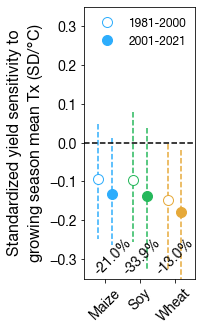

In [318]:

plt.figure(figsize=(2,5))
plt.xlim([.4, 3.6])
# plt.ylim([-.43, .25])

y_low = -.35
y_high = .35
plt.ylim([y_low, y_high])


plt.plot([.8, .8], [maize_yield_txx_sensitivity_1_low, maize_yield_txx_sensitivity_1_high], '--', c='#2dadfc')
plt.plot(.8, maize_yield_txx_sensitivity_1_mid, 'o', ms=10, c='#2dadfc', mfc='white', label='1981-2000')

plt.plot(1.2,maize_yield_txx_sensitivity_2_mid, 'o', ms=10, c='#2dadfc', label='2001-2021')
plt.plot([1.2, 1.2], [maize_yield_txx_sensitivity_2_low, maize_yield_txx_sensitivity_2_high], '--', c='#2dadfc')
plt.text(1-.4, y_low+.01, \
         '%.1f%%'%(np.round(maize_yield_txx_sensitivity_chg_pct,1)), fontsize=14, rotation=45)


plt.plot([1.8, 1.8], [soy_yield_txx_sensitivity_1_low, soy_yield_txx_sensitivity_1_high], '--', c='#25b85b')
plt.plot(1.8,soy_yield_txx_sensitivity_1_mid, 'o', ms=10, c='#25b85b', mfc='white')

plt.plot(2.2,soy_yield_txx_sensitivity_2_mid, 'o', ms=10, c='#25b85b')
plt.plot([2.2,2.2], [soy_yield_txx_sensitivity_2_low, soy_yield_txx_sensitivity_2_high], '--', c='#25b85b')
plt.text(2-.55, y_low+.01, \
         '%.1f%%'%(np.round(soy_yield_txx_sensitivity_chg_pct,1)), fontsize=14, rotation=45)


plt.plot([2.8, 2.8], [wheat_yield_txx_sensitivity_1_low, wheat_yield_txx_sensitivity_1_high], '--', c='#e6a939')
plt.plot(2.8,wheat_yield_txx_sensitivity_1_mid, 'o', ms=10, c='#e6a939', mfc='white')

plt.plot([3.2, 3.2], [wheat_yield_txx_sensitivity_2_low, wheat_yield_txx_sensitivity_2_high], '--', c='#e6a939')
plt.plot(3.2,wheat_yield_txx_sensitivity_2_mid, 'o', ms=10, c='#e6a939')

plt.text(3-.62, y_low+.01, \
         '%.1f%%'%(np.round(wheat_yield_txx_sensitivity_chg_pct,1)), fontsize=14, rotation=45)
# plt.text(3-.62, -.42, \
#          '%.1f%%'%(np.round(wheat_yield_txx_sensitivity_chg,1)), fontsize=16, fontfamily='helvetica', rotation=45)

plt.plot([.4, 3.6], [0,0], '--k')
plt.gca().set_xticks([1,2,3])
plt.gca().set_xticklabels(['Maize', 'Soy', 'Wheat'], rotation=45)

plt.legend(prop={'size': 12}, frameon=False, loc='upper left')

plt.ylabel('Standardized yield sensitivity to\ngrowing season mean Tx (SD/$\degree$C)')
# plt.savefig('crop-sensitivity-chg-high-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [333]:
irr_below_levels = np.array([100, 50, 20, 10, 5, 1])

maize_effect_irr_below = np.array([-23.2, -23.4, -22.8, -22.2, -21.7, -21])
soy_effect_irr_below = np.array([-36.7, -37, -35.6, -35.0, -34.4, -33.9])
wheat_effect_irr_below = np.array([-12.0, -12.7, -12.7, -12.8, -13.0, -13.0])

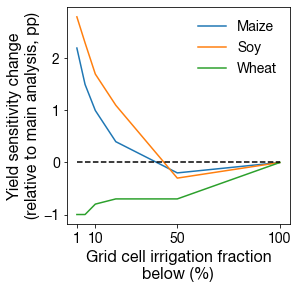

In [351]:
plt.figure(figsize=(4,4))
plt.plot(irr_below_levels, maize_effect_irr_below-maize_effect_irr_below[0], label='Maize')
plt.plot(irr_below_levels, soy_effect_irr_below-soy_effect_irr_below[0], label='Soy')
plt.plot(irr_below_levels, wheat_effect_irr_below-wheat_effect_irr_below[0], label='Wheat')
plt.plot([1,100], [0,0], '--k')
plt.xticks([1, 10, 50, 100])
plt.xlabel('Grid cell irrigation fraction\nbelow (%)')
plt.ylabel('Yield sensitivity change\n(relative to main analysis, pp)')
plt.legend(frameon=False, fontsize=14)
plt.savefig('irr-sens-test.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

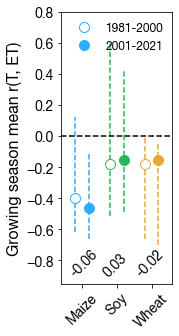

In [190]:

plt.figure(figsize=(2,5))
plt.xlim([.4, 3.6])
plt.ylim([-.95, .8])

plt.plot([.8, .8], [r_t_et_1_maize_low, r_t_et_1_maize_high], '--', c='#2dadfc')
plt.plot(.8, r_t_et_1_maize_mid, 'o', ms=10, c='#2dadfc', mfc='white', label='1981-2000')

plt.plot(1.2,r_t_et_2_maize_mid, 'o', ms=10, c='#2dadfc', label='2001-2021')
plt.plot([1.2, 1.2], [r_t_et_2_maize_low, r_t_et_2_maize_high], '--', c='#2dadfc')
# plt.text(1-.4, -.9, \
#          '%.1f%%'%(np.round(r_t_et_chg_maize_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
plt.text(1-.4, -.9, \
         '%.2f'%(np.round(r_t_et_chg_maize_val,2)), fontsize=14, rotation=45)


plt.plot([1.8, 1.8], [r_t_et_1_soy_low, r_t_et_1_soy_high], '--', c='#25b85b')
plt.plot(1.8,r_t_et_1_soy_mid, 'o', ms=10, c='#25b85b', mfc='white')

plt.plot(2.2,r_t_et_2_soy_mid, 'o', ms=10, c='#25b85b')
plt.plot([2.2,2.2], [r_t_et_2_soy_low, r_t_et_2_soy_high], '--', c='#25b85b')
# plt.text(2-.55, -.9, \
#          '%.1f%%'%(np.round(r_t_et_chg_soy_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
plt.text(2-.45, -.9, \
         '%.2f'%(np.round(r_t_et_chg_soy_val,2)), fontsize=14, rotation=45)


plt.plot([2.8, 2.8], [r_t_et_1_wheat_low, r_t_et_1_wheat_high], '--', c='#e6a939')
plt.plot(2.8,r_t_et_1_soy_mid, 'o', ms=10, c='#e6a939', mfc='white')

plt.plot([3.2, 3.2], [r_t_et_2_wheat_low, r_t_et_2_wheat_high], '--', c='#e6a939')
plt.plot(3.2,r_t_et_2_soy_mid, 'o', ms=10, c='#e6a939')

# plt.text(3-.62, -.9, \
#          '%.1f%%'%(np.round(r_t_et_chg_wheat_pct,1)), fontsize=16, fontfamily='helvetica', rotation=45)
plt.text(3-.52, -.9, \
         '%.2f'%(np.round(r_t_et_chg_wheat_val,2)), fontsize=14, rotation=45)

plt.plot([.4, 3.6], [0,0], '--k')
plt.gca().set_xticks([1,2,3])
plt.gca().set_xticklabels(['Maize', 'Soy', 'Wheat'], rotation=45)

plt.legend(prop={'size': 12}, frameon=False, loc='upper left')

plt.ylabel('Growing season mean r(T, ET)')
plt.savefig('crop-rt-et-chg-high-irr.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [ ]:
tmp_df = pd.DataFrame({"wheat_ha_regrid_2005_sel_1d": wheat_ha_regrid_2005_sel_1d[nn2_wheat][nn3_wheat], \
                       "yield_chg_wheat": yield_chg_wheat, \
                       "r_t_et_chg_wheat": r_t_et_chg_wheat})
bin_edges = np.arange(0,1,.1)
bins = pd.cut(tmp_df["wheat_ha_regrid_2005_sel_1d"], bin_edges, right=False, include_lowest=True)
wheat_ha_regrid_2005_sel_1d_binned = tmp_df.groupby(bins)["wheat_ha_regrid_2005_sel_1d"].mean().to_numpy()
r_t_et_chg_wheat_binned = tmp_df.groupby(bins)["r_t_et_chg_wheat"].mean().to_numpy()
yield_chg_wheat_binned = tmp_df.groupby(bins)["yield_chg_wheat"].mean().to_numpy()


tmp_df = pd.DataFrame({"maize_ha_regrid_2005_sel_1d": maize_ha_regrid_2005_sel_1d[nn2_maize][nn3_maize], \
                       "yield_chg_maize": yield_chg_maize, \
                       "r_t_et_chg_maize": r_t_et_chg_maize})
bin_edges = np.arange(0,1,.1)
bins = pd.cut(tmp_df["maize_ha_regrid_2005_sel_1d"], bin_edges, right=False, include_lowest=True)
maize_ha_regrid_2005_sel_1d_binned = tmp_df.groupby(bins)["maize_ha_regrid_2005_sel_1d"].mean().to_numpy()
r_t_et_chg_maize_binned = tmp_df.groupby(bins)["r_t_et_chg_maize"].mean().to_numpy()
yield_chg_maize_binned = tmp_df.groupby(bins)["yield_chg_maize"].mean().to_numpy()


# tmp_df = pd.DataFrame({"soy_ha_regrid_2005_sel_1d": soy_ha_regrid_2005_sel_1d[nn2_soy][nn3_soy], \
#                        "yield_chg_soy": yield_chg_soy, \
#                        "r_t_et_chg_soy": r_t_et_chg_soy})
# bin_edges = np.linspace(0, 1, 100)
# bins = pd.cut(tmp_df["soy_ha_regrid_2005_sel_1d"], bin_edges, right=False, include_lowest=True)
# r_t_et_chg_soy_binned = tmp_df.groupby(bins)["r_t_et_chg_soy"].mean().to_numpy()
# yield_chg_soy_binned = tmp_df.groupby(bins)["yield_chg_soy"].mean().to_numpy()


In [ ]:


nn = np.where((~np.isnan(r_t_et_chg_wheat)) & (~np.isnan(yield_chg_wheat)))[0]


X = sm.add_constant(r_t_et_chg_wheat[nn])
mdl1 = sm.OLS(yield_chg_wheat[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

# plt.scatter(r_t_et_chg_binned, maize_yield_chg_by_cf_bin, c='#2dadfc', s=10+cf_bins*100)
# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#25b85b', s=10+cf_bins*100)
plt.scatter(r_t_et_chg_wheat, yield_chg_wheat, c='#e6a939')

plt.plot([x1, x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl1.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in maize yield:\n2001-2016 minus 1981-2000')
plt.legend(prop={'size': 16}, frameon=False)

# plt.savefig('chg-r-t-et-vs-chg-yield-wheat.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:


nn = np.where((~np.isnan(r_t_et_chg_soy)) & (~np.isnan(yield_chg_soy)))[0]


X = sm.add_constant(r_t_et_chg_soy[nn])
mdl1 = sm.OLS(yield_chg_soy[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#2dadfc', s=10+cf_bins*100)
# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#25b85b', s=10+cf_bins*100)
plt.scatter(r_t_et_chg_soy, yield_chg_soy, c='#25b85b')

plt.plot([x1, x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl1.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in soy yield:\n2001-2016 minus 1981-2000')
plt.legend(prop={'size': 16}, frameon=False)

plt.savefig('chg-r-t-et-vs-chg-yield-soy.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [ ]:


nn = np.where((~np.isnan(r_t_et_chg_maize)) & (~np.isnan(yield_chg_maize)))[0]


X = sm.add_constant(r_t_et_chg_maize[nn])
mdl1 = sm.OLS(yield_chg_maize[nn], X).fit()

x1 = -1.2
x2 = 1

plt.figure(figsize=(4,4))

# plt.scatter(r_t_et_chg_binned, maize_yield_chg_by_cf_bin, c='#2dadfc', s=10+cf_bins*100)
# plt.scatter(r_t_et_chg_binned, soy_yield_chg_by_cf_bin, c='#25b85b', s=10+cf_bins*100)
plt.scatter(r_t_et_chg_maize, yield_chg_maize, c='#2dadfc')

plt.plot([x1, x2], [mdl1.params[0]+x1*mdl1.params[1], mdl1.params[0]+x2*mdl1.params[1]], '--k', lw=3, label='$R^2$ = %.2f'%mdl1.rsquared)

plt.xlabel('Change in r(T, ET):\n2001-2021 minus 1981-2000')
plt.ylabel('Change in maize yield:\n2001-2016 minus 1981-2000')
plt.legend(prop={'size': 16}, frameon=False)

plt.savefig('chg-r-t-et-vs-chg-yield-maize.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
